In [467]:
#for importing, formatting and data manipulation
import pandas as pd
import numpy as np
import glob
import datetime
#from time import time
#from datetime import datetime
#from datetime import timedelta
import tempfile
from qiime2 import Artifact
import zipfile
import yaml
import json

#for plotting
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from matplotlib_venn import venn3, venn3_circles
from matplotlib.patches import Patch
import seaborn as sns
#sns.set(style="whitegrid")
import plotly.express as px
%matplotlib inline
from IPython.display import display
from upsetplot import plot
#import pyupset as pyu
pd.set_option('display.max_rows', 15)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
from pandas.plotting import register_matplotlib_converters
from mpl_toolkits.mplot3d import Axes3D
import plotly.graph_objects as go
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX
register_matplotlib_converters()

#for statistical analyses
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.covariance import EllipticEnvelope
from sklearn.ensemble import IsolationForest
from skbio.diversity import alpha_diversity
from skbio.stats.distance import permanova
from skbio import DistanceMatrix
from scipy.spatial.distance import cdist
from skbio.stats.composition import clr
from skbio.stats.composition import alr
from skbio.stats.composition import ilr
from skbio.diversity.alpha import chao1
from skbio.stats.composition import ancom
import scipy.stats as stats
import statsmodels.api as sa
import statsmodels.formula.api as sfa
import scikit_posthocs as sp

## Import and format metadata from lab, and BBMP

### Import lab metadata

In [2]:
def load_df():
    
    filenames = glob.glob('/Users/Diana/Documents/escuela/phd/ch2/bb_data/20**/METADATA.txt')
    #load all metadata and concatenate them into one dataframe
    md = []
    for filename in filenames:
        df = pd.read_csv(filename, sep='\t')
        md.append(df)
        print (filename)
    
    md = pd.concat(md)
    
    #drop empty columns and rows
    md.dropna(how='all', axis=1, inplace=True) #empty cols
    md.dropna(how='all', inplace=True) #empty rows
    
    return md

In [3]:
md = load_df()

/Users/Diana/Documents/escuela/phd/ch2/bb_data/2014/METADATA.txt
/Users/Diana/Documents/escuela/phd/ch2/bb_data/2022/METADATA.txt
/Users/Diana/Documents/escuela/phd/ch2/bb_data/2015/METADATA.txt
/Users/Diana/Documents/escuela/phd/ch2/bb_data/2017/METADATA.txt
/Users/Diana/Documents/escuela/phd/ch2/bb_data/2019/METADATA.txt
/Users/Diana/Documents/escuela/phd/ch2/bb_data/2021/METADATA.txt
/Users/Diana/Documents/escuela/phd/ch2/bb_data/2020/METADATA.txt
/Users/Diana/Documents/escuela/phd/ch2/bb_data/2018/METADATA.txt
/Users/Diana/Documents/escuela/phd/ch2/bb_data/2016/METADATA.txt


#### Renumber dates

In [4]:
#create a dictionary for months
month_dic = {
    "Jan": 1,
    "Feb": 2,
    "Mar": 3,
    "Apr": 4,
    "May": 5,
    "Jun": 6,
    "Jul": 7,
    "Aug": 8,
    "Sep": 9,
    "Oct": 10,
    "Nov": 11,
    "Dec": 12
}
month_season = {
    "Jan": "Winter",
    "Feb": "Winter",
    "Mar": "Spring",
    "Apr": "Spring",
    "May": "Spring",
    "Jun": "Summer",
    "Jul": "Summer",
    "Aug": "Summer",
    "Sep": "Autumn",
    "Oct": "Autumn",
    "Nov": "Autumn",
    "Dec": "Winter"
}
depth_num = {
    "A": 1,
    "B": 5,
    "C": 10,
    "D": 60,
    "E": 30
}

In [5]:
#add month to a new column
md['month_name'] = md['date'].str.split('-').str[1]

#add month number
md['month']= md['month_name'].map(month_dic)

#add day number
md['day'] = md['date'].str.split('-').str[0]
md[["year", "month", "day"]] = md[["year", "month", "day"]].apply(pd.to_numeric)

#remove symbol for better handling of data
#md.rename(columns={"Week#": "Weekn"}, inplace=True)
#md.rename(columns={"Depth": "depth"}, inplace=True) #to match dfo

#change to int to remove decimals from date columns
md.year = md.year.apply(int)
md.depth = md.depth.apply(int)
md.weekn = md.weekn.apply(int)

#change to str to aggregate them into time_string to match dfos formatting of the date
md.year = md.year.apply(str)
md.month = md.month.apply(str)
md.day = md.day.apply(str)
#add leading zero to match date format in dfo metadata
md['month'] = md['month'].str.zfill(2)
md['day'] = md['day'].str.zfill(2)

#add leading zero to match date format in dfo metadata
md['month'] = md['month'].str.zfill(2)
md['day'] = md['day'].str.zfill(2)

md['time_string'] = md[['year', 'month', 'day']].agg('-'.join, axis=1)

### Import and manage BBMP data

#### Metadata __md__ is formatted. It contains 38 columns.
__md__ is the lab's metadata for sampling, extraction and sequencing. \
__dfo_md__ is BBMP remote sensing data (salinity, pH, temperature, density..) \
__bio_niskin__ is nutrient data \
Format __bio_niskin__ data to merge with __md__. __bio_niskin__ is 32 columns, including year, month, day, and depth. __dfo_md__ also has 32 columns, including year_time, month_time, day_time. To merge these data with __md__, we will change the time stamps columns to the same name, and generate a time_string column.

In [6]:
dfo_md = pd.read_csv("/Users/Diana/Documents/escuela/phd/ch2/bb_data/bbmp_aggregated_profiles.csv")
bio_niskin = pd.read_csv("/Users/Diana/Documents/escuela/phd/ch2/bb_data/BBMP_Data_2022.csv")#
#dfo_metadata_y14 = pd.read_csv("/Users/Diana/Documents/escuela/phd/bb_data/2019/data_export/trim-analysis/dfo_metadata_y14.tsv", sep='\t')

#change to str to aggregate them into time_string
bio_niskin.year = bio_niskin.year.apply(str)
bio_niskin.month = bio_niskin.month.apply(str)
bio_niskin.day = bio_niskin.day.apply(str)
#add leading zero to match date format in dfo metadata
bio_niskin['month'] = bio_niskin['month'].str.zfill(2)
bio_niskin['day'] = bio_niskin['day'].str.zfill(2)

bio_niskin['time_string'] = bio_niskin[['year', 'month', 'day']].agg('-'.join, axis=1)

#make a new column for time_string without the time
dfo_md['time_string_time'] = dfo_md['time_string']
dfo_md['time_string'] = dfo_md['time_string'].str.split(' ').str[0]

#renaming columns to ensure correct merging
dfo_md.rename(columns={"depth":"bbmpdepth","pressure": "depth", "year_time": "year", "month_time": "month", "day_time": "day"}, inplace=True)

#change to int to remove decimals from date columns
cols = ['year', 'depth', 'month', 'day']
md[cols] = md[cols].apply(pd.to_numeric, errors='ignore', axis=1)
dfo_md[cols] = dfo_md[cols].apply(pd.to_numeric, errors='ignore', axis=1)
bio_niskin[cols] = bio_niskin[cols].apply(pd.to_numeric, errors='ignore', axis=1)

#make a season column
md['season'] = ''

for month, season in month_season.items():
    md.loc[md['month_name'] == month, 'season'] = season

#merging party
merged = pd.merge(md, dfo_md, on=["year", "month", "depth", "day"], how="left")
allyears = pd.merge(md, dfo_md, on=["year", "month", "depth", "day"], how="outer")

#add nutrient data
preall_md= pd.merge(allyears, bio_niskin, on=["day", "month", "year", 'depth'], how="outer")
all_md = pd.merge(merged, bio_niskin, on=["day", "month", "year", 'depth'], how="left")

#split dfs by depth
shallow_depths = [1, 5, 10]
shallow = all_md[all_md["depth"] < 30]
#shallow = shallow.groupby(['year', 'month', "day"]).mean().reset_index()
deep = all_md[all_md.depth == 60]

#split dfs by season
year_season = preall_md.groupby(by = ['year','season']).mean().reset_index()

Winter = year_season.loc[year_season['season'] == 'Winter',:]
Spring = year_season.loc[year_season['season'] == 'Spring',:]
Summer = year_season.loc[year_season['season'] == 'Summer',:]
Autumn = year_season.loc[year_season['season'] == 'Autumn',:]

#save output as csv
all_md.to_csv('allmetadata.csv')

/var/folders/kv/yq6jygk116l27q2bwnk25k0w0000gn/T/ipykernel_64907/2823838939.py:35: UserWarning: You are merging on int and float columns where the float values are not equal to their int representation.
  merged = pd.merge(md, dfo_md, on=["year", "month", "depth", "day"], how="left")
/var/folders/kv/yq6jygk116l27q2bwnk25k0w0000gn/T/ipykernel_64907/2823838939.py:36: UserWarning: You are merging on int and float columns where the float values are not equal to their int representation.
  allyears = pd.merge(md, dfo_md, on=["year", "month", "depth", "day"], how="outer")
/var/folders/kv/yq6jygk116l27q2bwnk25k0w0000gn/T/ipykernel_64907/2823838939.py:40: UserWarning: You are merging on int and float columns where the float values are not equal to their int representation.
  all_md = pd.merge(merged, bio_niskin, on=["day", "month", "year", 'depth'], how="left")
/var/folders/kv/yq6jygk116l27q2bwnk25k0w0000gn/T/ipykernel_64907/2823838939.py:49: FutureWarning: The default value of numeric_only in

## Find missing data

In [7]:
emptynit = all_md[all_md['Nitrate'].isna()]

## Plotting party

In [ ]:
#plotly seasonal averages figure
fig2 = go.Figure()
for template in ["plotly_white"]:
    fig2.add_trace(go.Scatter(x=Winter['year'], y=Winter['temperature'],
                    mode='lines',
                    name='Winter',
                    marker_color='#838B8B'))
    fig2.add_trace(go.Scatter(x=Spring['year'], y=Spring['temperature'],
                    mode='lines',
                    name='Spring',
                    marker_color='#FFB5C5'))
    fig2.add_trace(go.Scatter(x=Summer['year'], y=Summer['temperature'],
                    mode='lines',
                    name='Summer',
                    marker_color='#87CEFF'))
    fig2.add_trace(go.Scatter(x=Autumn['year'], y=Autumn['temperature'],
                    mode='lines',
                    name='Autumn',
                    marker_color='#FF8000'))
    fig2.update_layout(
    height=800,
    xaxis_title="Years",
    yaxis_title='Temperature in degree',
    title_text='Average Temperature seasonwise over the years',
    template=template)

fig2.show()

In [ ]:
#seaborn season averages plot
sns.lineplot(year_season['year'],year_season['temperature'], hue =year_season["season"])

In [ ]:
plt.style.use('ggplot')

### Detect and plot anomalies in variables

In [ ]:
def detect_anomalies(metadata, depth, yr=all, month=all):
    md_col = depth[['weekn', metadata, "year", "month"]].copy()
    md_col = md_col[md_col[metadata].notna()]
    if yr != all:
        #mdcol_yr = md_col[md_col.Year == yr]
        mdcol_yr = md_col[md_col['year'].isin(yr)]
    else: 
        mdcol_yr = md_col
        
    if month != all:
        #mdcol_yr = mdcol_yr[mdcol_yr.Month == month]
        mdcol_yr = mdcol_yr[mdcol_yr['month'].isin(month)]
    
    mdcol_yr = mdcol_yr.drop(columns=['year', "month"])
    mdcol_yr = mdcol_yr.set_index(['weekn'])
    
    #modelling time
    outliers_fraction = float(.01)
    scaler = StandardScaler()
    np_scaled = scaler.fit_transform(mdcol_yr.values.reshape(-1, 1))
    data = pd.DataFrame(np_scaled)
    # train isolation forest
    model =  IsolationForest(contamination=outliers_fraction)
    model.fit(data)
    
    #predict data
    mdcol_yr['anomaly'] = model.predict(data)
    
    
    # visualization
    fig, ax = plt.subplots(figsize=(10,6))
    a = mdcol_yr.loc[mdcol_yr['anomaly'] == -1, [metadata]] #anomaly
    ax.plot(mdcol_yr.index, mdcol_yr[metadata], color='black', label = 'Normal')
    ax.scatter(a.index,a[metadata], color='red', label = 'Anomaly')
    plt.axvline(36, ls='--')
    plt.legend()
    plt.show();
    #add axes names

In [ ]:
detect_anomalies('Phosphate', shallow, yr={2022}, month={1,2,3})

## Add prokaryotic community

#### Upload functions

In [77]:
# Special thanks to Alex Manuele https://github.com/alexmanuele
def consolidate_tables(MG):
    if MG == '16S':
        comm = '02-PROKs'
    else :
        comm = '02-EUKs'
        
    table_list = glob.glob('{0}/table.qza'.format('/Users/Diana/Documents/escuela/phd/size_fractions/BB22_size-fraction-comparison-analysed/to_transfer/'+comm))
    print("Found all "+MG+" tables.")

        
    dataframes = []  
    for table_path in table_list:
        with tempfile.TemporaryDirectory() as tempdir:
            #load table, dump contents to tempdir
            table = Artifact.load(table_path)
            #Make sure the tables are all FeatureFrequency type
            assert str(table.type) == 'FeatureTable[Frequency]', "{0}: Expected FeatureTable[Frequency], got {1}".format(table_path, table.type)
            Artifact.extract(table_path, tempdir)
            #get the provenance form the tempdir and format it for DF
            prov = '{0}/{1}/provenance/'.format(tempdir, table.uuid)
            action = yaml.load(open("{0}action/action.yaml".format(prov), 'r'), Loader=yaml.BaseLoader)
            paramlist = action['action']['parameters']
            paramlist.append({'table_uuid': "{}".format(table.uuid)})
            paramdict = {}
            for record in paramlist:
                paramdict.update(record)

            # Get the data into a dataframe
              #Biom data
            df = table.view(pd.DataFrame).unstack().reset_index()
            df.columns = ['feature_id', 'sample_name', 'feature_frequency']
            df['table_uuid'] = ["{}".format(table.uuid)] * df.shape[0]
              #param data
            pdf = pd.DataFrame.from_records([paramdict])
              #merge params into main df
            df = df.merge(pdf, on='table_uuid')
            

            #I like having these columns as the last three. Makes it more readable
            cols = df.columns.tolist()
            reorder = ['sample_name', 'feature_id', 'feature_frequency']
            for val in reorder:
                cols.append(cols.pop(cols.index(val)))
            df = df[cols]
            df['table_path'] = [table_path] * df.shape[0]
            df['sample_name'] = df['sample_name'].str.replace('-', '.')
            dataframes.append(df)
            
            # Adding table_id, forward and reverse trim columns
            #df['table_id'] = str(table_path.split('/')[-3]) #add a table_id column
            #df['forward_trim'], df['reverse_trim'] = df['table_id'].str.split('R', 1).str
            #df['forward_trim'] = df['forward_trim'].map(lambda x: x.lstrip('F'))
            #df["forward_trim"] = pd.to_numeric(df["forward_trim"])
            #df["reverse_trim"] = pd.to_numeric(df["reverse_trim"])

    #Stick all the dataframes together
    #outputfile="merged_all_tables.tsv"
    df = pd.concat(dataframes)
    df['sample_name'] = df['sample_name'].str.replace(r'\.S([1-9]|[1-9][0-9]|[1-9][0-9][0-9]).L001\.','', regex=True)
    
    #df.to_csv(comm+'/merged_all_tables.tsv', sep='\t', index=False)
    print("Successfully saved all tables.")
    return df, comm

In [9]:
def merge_metadata(df):
    #df = pd.read_csv('02-PROKs/'+'/merged_all_tables.tsv', sep='\t')

    tables = df[['sample_name', 'feature_id', 'feature_frequency']].copy()
    tables.rename(columns={'sample_name':'sampleid'}, inplace=True)

    all_md['sampleid'] = all_md['sampleid'].str.replace('_', '.')
    merged = pd.merge(tables,all_md, on='sampleid', how='left') #all_md is the metadata file
    merged = merged[merged.feature_frequency != 0]
    
    merged['year'] = 2022
    merged["size_code"] = ''

    merged["size_code"] = merged["sampleid"].str.extract(r'[1-9][0-9]?[A-E]([L-S])')
    merged["size_code"] = merged["size_code"].fillna('W')
    merged["depth_code"] = merged["sampleid"].str.extract(r'[1-9][0-9]?([A-E])')
    merged['depth']= merged['depth_code'].map(depth_num)
    merged["weekn"] = merged["sampleid"].str.extract(r'\.([1-9][0-9]?)[A-E]')
    merged['weekn'] = pd.to_numeric(merged['weekn'])
    merged['depth'] = pd.to_numeric(merged['depth'])
    merged['date'] = merged.groupby('weekn', as_index=False)['date'].transform('first')
    
    merged['Total'] = merged['feature_frequency'].groupby(merged['sampleid']).transform('sum')
    merged['ratio'] = merged['feature_frequency']/merged['Total']
    merged['nASVs'] = merged['feature_id'].groupby(merged['sampleid']).transform('count')
    merged['weekdepth'] = merged["weekn"].astype(str) + merged["depth"].astype(str)
    merged['avg'] = merged['nASVs'].groupby(merged['weekdepth']).transform('mean')
    merged['diff'] = merged['nASVs'] - merged['avg']

    print('Set up metadata ...')
    
    #merged.to_csv(comm+'/merged_asvs_metadata.tsv', sep = '\t')
    print('Saved merged_asvs_metadata.tsv')
    
    return merged

In [596]:
def pick_metadata(merged, depth='all', size_fraction='both', year='all', R='all', F='all', txsubset = 'all'):
#make df of features/composition+run+comm

    depth = depth
    year = year
    size_fraction = size_fraction
    txsubset = txsubset
        
    files = glob.glob('{0}/*/class/*/data/taxonomy.tsv'.format('/Users/Diana/Documents/escuela/phd/size_fractions/BB22_size-fraction-comparison-analysed/to_transfer'))
    taxos = []
#    if not os.path.exists(path+composition):
#        os.mkdir(path+composition)
    for filename in files:
        tax = pd.read_csv(filename, sep='\t')
        taxos.append(tax)
        
    print('Appended all taxonomies to taxos')
    taxos = pd.concat(taxos)
    taxos = taxos.rename(columns={"Feature ID": "feature_id"}, errors="raise")
    taxos = taxos.drop_duplicates()

    separated = merged.merge(taxos, how='left', on='feature_id') #merged excludes features of frequency = 0
    separated = separated.drop_duplicates()
    
    if depth != 'all':
        separated = separated[separated["depth"] == depth]
    if size_fraction != 'both':
        separated = separated[separated["size_fraction"] == size_fraction]

    separated[['Domain', 'Phylum', 'Class', 'Order', 'Family', 'Genus', 'Species']] = separated['Taxon'].str.split('; ', expand=True)
    cols = ['Domain', 'Phylum', 'Class', 'Order', 'Family', 'Genus', 'Species']
    for col in cols:
        separated[col] = separated[col].fillna('Unassigned')
        
    separated['Month'] = separated['date'].str.split('-').str[1]
    
    #separated['total'] = separated.groupby(['table_id','sample-id'])['feature_frequency'].transform('sum')
    #separated['ratio'] = separated['feature_frequency']/(separated['total'])
    #separated_taxonomies = separated.copy()
    
    #make a dictionary with keys for id-ing the taxon belonging to this sub-community
    #separated_dic = pd.Series(separated.Taxon.values,separated.feature_id.values).to_dict()
    print('Saved separated by metadata dataframe.')
    
    return separated

In [17]:
def taxbarplot(separated, level, depth, topn): #separated is the df, #level is a string of taxonomic level column name, depth is an integer
    sfd=separated[separated.depth==depth]
    toptaxa = sfd[['feature_id', 'feature_frequency', 'Taxon', 'size_code', 'depth','weekn', level]].copy()
    toptaxa = toptaxa.drop_duplicates()
    df_agg = toptaxa.groupby(['size_code',level, 'depth']).agg({'feature_frequency':sum})
    topd = df_agg['feature_frequency'].groupby('size_code', group_keys=False).nlargest(topn)
    topd = topd.to_frame()
    topd = topd.reset_index()

    df_agg = df_agg.reset_index()
    df_agg['set_name'] = df_agg['size_code']+df_agg['depth'].astype(str)
    
    cumulab = separated[['feature_frequency', 'depth', 'size_code', 'Genus']].copy()
    cumulab1 = cumulab.groupby(['Genus']).agg({'feature_frequency':sum})

    resultpivot = df_agg.pivot_table(index=level, columns='set_name', values='feature_frequency')
    resultpivot = resultpivot.fillna(0)
    resultpivot[resultpivot != 0] = 1
    tosave = pd.merge(resultpivot, cumulab1, left_index=True, right_index=True)
    tosave.to_csv(level+'_'+str(depth)+'16S_relab.csv')
    
    top10d_list = topd[level].unique()
    top10d = sfd.copy()
    top10d.loc[~top10d[level].isin(top10d_list), level] = 'Other' #isnot in top list
    phyld = top10d.groupby(['size_code','weekn', level])['ratio'].sum()
    phyld = phyld.reset_index()


    fig = px.bar(phyld, x="size_code", y="ratio", facet_col="weekn", color=level, labels={
                     "feature_frequency": "Relative abundance",
                     "size_code": "",
                     "weekn": "w"})# color_discrete_map=colors_dict)
    fig.update_xaxes(type='category', dtick=1)
    fig.update_layout(
        title="Relative abundance of top 10" + level + 'observed at Depth' + str(depth),
        yaxis_title="Relative abundance",
        xaxis_title="Size fraction",
        legend_title=level,
        font=dict(size=8)
    )

    fig.show()
    #fig.write_image("outputs/fig1.png")
    #fig.to_image(format="png")

In [484]:
def pcaplot(separated, depth, comm):
    
    if comm == '16S':
        folder = '02-PROKs'
    else:
        folder = '02-EUKs'
    df=separated[separated.depth==depth]
    #df=separated.copy()
    
    #sizecode palette codes
    sizecodes = ['S', 'L', 'W']
    palette_colors = sns.color_palette()
    palette_dict = {sizecode: color for sizecode, color in zip(sizecodes, palette_colors)}
    dicsc = pd.Series(df.size_code.values,index=df.sampleid).to_dict()
    color_rows_sc = {k: palette_dict[v] for k, v in dicsc.items()}
    seriescr = pd.Series(color_rows_sc)
    
    #month palette code
    df['Month'] = df['date'].str.split('-').str[1]
    months = ['Jan', 'Feb', 'Mar', 'May', 'Apr']
    palette_colors = sns.color_palette("flare")
    palette_dict_month = {monthname: color for monthname, color in zip(months, palette_colors)}
    dic = pd.Series(df.Month.values,index=df.sampleid).to_dict()
    color_rows_month = {k: palette_dict_month[v] for k, v in dic.items()}
    seriesmonthcr = pd.Series(color_rows_month)

    dfcolors = pd.DataFrame({'Month': seriesmonthcr,'Size code':seriescr})
    
    sfdpiv= df.pivot(index='sampleid', columns='feature_id', values='feature_frequency')
    sfdpiv=sfdpiv.fillna(0)
    sfdclr=sfdpiv.mask(sfdpiv==0).fillna(0.1)
    clr_transformed_array = clr(sfdclr)
    samples = sfdpiv.index
    asvs = sfdpiv.columns
    
    #Creating the dataframe with the clr transformed data, and assigning the sample names
    clr_transformed = pd.DataFrame(clr_transformed_array, columns=asvs)
    #Assigning the asv names
    clr_transformed['samples'] = samples
    clr_transformed = clr_transformed.set_index('samples')
    clr_transformed.head()

    #calculate distance matrix
    dist = cdist(clr_transformed, clr_transformed, 'euclid')
    distance_matrix = pd.DataFrame(dist, columns=samples)
    distance_matrix['samples'] = samples
    distance_matrix = distance_matrix.set_index('samples')

    #format for pca
    dm = DistanceMatrix(distance_matrix)

    pca = PCA(n_components=2)
    pca_features = pca.fit_transform(distance_matrix)
    
    ####
    sns.set(rc={"figure.figsize":(4, 3)})
    sns.set_style("whitegrid", {'axes.grid' : False})
    plot_df = pd.DataFrame(data = pca_features, columns = ['dim1', 'dim2'], index = sfdpiv.index)
    plot_df['dim1'] = plot_df['dim1']/1000
    plot_df['dim2'] = plot_df['dim2']/1000
    plot_df2 = pd.merge(plot_df,df[['sampleid','size_code','weekn']],on='sampleid', how='left')
    
    #plot
    ax=sns.scatterplot(x = 'dim1', y = 'dim2', size = 'weekn', hue= 'size_code', style="size_code", data = plot_df2,palette=palette_dict) #,palette=sns.color_palette("dark:salmon_r", as_cmap=True))
    plt.ylabel('Component 2')
    plt.xlabel('Component 1')
    sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
    plt.savefig('outputs/'+folder+'/D'+str(depth)+'_PCAplot.png', dpi=200, bbox_inches="tight")
    plt.clf()
    plt.cla()
    plt.close()
    
    ##clustermap
    ax = sns.clustermap(distance_matrix, method="complete", cmap='RdBu', annot=True,
               yticklabels=True, row_colors = dfcolors,
               annot_kws={"size": 7}, figsize=(15,12));

    handles1 = [Patch(facecolor=palette_dict_month[key]) for key in palette_dict_month]
    plt.legend(handles1, palette_dict_month, title='Month',
               bbox_to_anchor=(1, 1), bbox_transform=plt.gcf().transFigure, loc='upper left')
    
    plt.savefig('outputs/'+folder+'/D'+str(depth)+'_clustermap.png', dpi=200, bbox_inches="tight")


    return pca, pca_features, sfdclr

In [436]:
def boxplot_depth(separated, comm, depth, ycolumn, yaxislabel='def'):
    
    if comm == '16S':
        comm_id = '02-PROKs'
    else:
        comm_id = '02-EUKs'
    
    if yaxislabel != 'def':
        ycol = ycolumn
    
    sfd=separated[separated.depth==depth]
    
    #sfd_S = sfd[['size_code', 'nASVs', 'weekn']].copy()
    #sfd_S = sfd_S.drop_duplicates()
    #sdfpv = sfd_S.pivot(index='weekn', columns='size_code', values='nASVs')
    #fvalue, pvalue = stats.f_oneway(sdfpv['L'], sdfpv['S'], sdfpv['W'])
    
    sfd_LM = sfd[['size_code', 'nASVs']].copy()
    sfd_LM = sfd_LM.drop_duplicates()
    lm = sfa.ols('nASVs ~ C(size_code)', data=sfd_LM).fit()
    anova = sa.stats.anova_lm(lm)
    results = sp.posthoc_ttest(sfd_LM, val_col='nASVs', group_col='size_code', p_adjust='holm')
    
    #define color palettes
    sizecodes = ['S', 'L', 'W']
    palette_colors = sns.color_palette()
    palette_dict = {sizecode: color for sizecode, color in zip(sizecodes, palette_colors)}
    
    #plot
    sns.set(rc={"figure.figsize":(4, 3)})
    sns.boxplot(data=sfd, x="size_code", y=ycolumn, palette=palette_dict, order=['S', 'L', 'W'])#, hue="size_code")
    plt.ylabel(yaxislabel)
    plt.xlabel('Size fraction')
    plt.savefig('outputs/'+comm_id+'/D'+str(depth)+'_adboxplot.png', dpi=200, bbox_inches="tight")
    plt.clf()
    plt.cla()
    plt.close()
    
    sns.set(rc={"figure.figsize":(7, 3)})
    ax=sns.barplot(data=sfd, x="weekn", y="diff", hue="size_code", palette=palette_dict)#, hue="size_code")
    plt.ylabel('Number of ASVs relative to weekly average')
    plt.xlabel('Week number')
    plt.savefig('outputs/'+comm_id+'/D'+str(depth)+'_avgbarplot.png', dpi=200, bbox_inches="tight")

    plt.clf() 
    sns.set(rc={"figure.figsize":(7, 3)})
    ax=sns.lineplot(x = "weekn", y = ycolumn, data=sfd, hue="size_code", palette=palette_dict)
    plt.ylabel(yaxislabel)
    plt.xlabel('Week')
    plt.legend(title='Size fraction')
    sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
    plt.savefig('outputs/'+comm_id+'/D'+str(depth)+'_adlineplot.png', dpi=200, bbox_inches="tight")
    
    return results

In [105]:
def upsetprep(comm, level, separated):
    if comm == '16S':
        comm_id = '02-PROKs'
    else:
        comm_id = '02-EUKs'
        
    depths = [1, 5, 10, 30, 60]
    
    cumulab = separated[['feature_frequency', 'depth', 'size_code', level]].copy()
    cumulab1 = cumulab.groupby([level]).agg({'feature_frequency':sum})
    
    for d in depths:
        #make csv
        sfd=separated[separated.depth==d]
        
        toptaxa = sfd[['feature_id', 'feature_frequency', 'Taxon', 'size_code', 'depth','weekn', level]].copy()
        toptaxa = toptaxa.drop_duplicates()
        df_agg = toptaxa.groupby(['size_code',level, 'depth']).agg({'feature_frequency':sum})
        topd = df_agg['feature_frequency'].groupby('size_code', group_keys=False).nlargest(10)
        topd = topd.to_frame()
        topd = topd.reset_index()

        df_agg = df_agg.reset_index()
        df_agg['set_name'] = df_agg['size_code']+df_agg['depth'].astype(str)
    
        resultpivot = df_agg.pivot_table(index=level, columns='set_name', values='feature_frequency')
        resultpivot = resultpivot.fillna(0)
        resultpivot[resultpivot != 0] = 1
        tosave = pd.merge(resultpivot, cumulab1, left_index=True, right_index=True)
        tosave.to_csv('csvs/'+comm_id+'/'+level+'_d'+str(d)+'_relab.csv')
        
        
        #make json
        data = {
            "file": "https://raw.githubusercontent.com/dianahaider/size_fractions/main/csvs/"+comm_id+'/'+level+'_d'+str(d)+'_relab.csv',
            "name": comm + level,
            "header": 0,
            "separator": ",",
            "skip": 0,
            "meta":[
                {"type":"id", "index":0, "name":"Name"},
                {"type":"integer", "index":4, "name":"Rel. ab."}
            ],
            "sets": [
                {"format": "binary", "start":1, "end": 3}
            ]
        }
        
        with open('json/'+comm_id+'/'+level+'_d'+str(d)+'.json', 'w') as f:
            json.dump(data, f)

In [588]:
def plot_per_fid(comm, separated, depth, fid):
    
    if comm == '16S':
        comm_id = '02-PROKs'
    else:
        comm_id = '02-EUKs'
    
    sizecodes = ['S', 'L', 'W']
    palette_colors = sns.color_palette()
    palette_dict = {sizecode: color for sizecode, color in zip(sizecodes, palette_colors)}
    
    sfd=separated[separated.depth==depth]
    sfd['weekfid'] = sfd["weekn"].astype(str) + sfd["feature_id"].astype(str)
    sfd['avg_p_id'] = sfd['ratio'].groupby(sfd['weekfid']).transform('mean')
    sfd['diff_p_id'] = sfd['ratio'] - sfd['avg_p_id']
    
    sfd_f=sfd[sfd.feature_id==fid]
    
    ttl = sfd_f['Taxon'].iloc[0]
    
    sns.set(rc={"figure.figsize":(7, 3)})
    ax=sns.barplot(data=sfd_f, x="weekn", y="diff_p_id", hue="size_code", palette=palette_dict)#, hue="size_code")
    sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
    plt.title(ttl)
    plt.ylabel('Ratio difference')
    plt.xlabel('Week number')
    plt.savefig('outputs/'+comm_id+'/D'+str(depth)+fid+'.png', dpi=200, bbox_inches="tight")

In [594]:
def run_ancom(sfdclr, depth, ancomcol):
    
    sfd=separated[separated.depth==depth]

        
    df_ancom = sfd[['sampleid', ancomcol]].copy()
    df_ancom = df_ancom.drop_duplicates()
    df_ancom = df_ancom.set_index('sampleid')
    
    results = ancom(table=sfdclr, grouping=df_ancom[ancomcol])
    
    DAresults = results[0].copy()
    DARejected_SC = DAresults.loc[DAresults['Reject null hypothesis'] == True]
    DARejected_SC.sort_values(by=['W'])
    
    taxonomy = sfd[['feature_id', 'Confidence', 'Taxon', 'Phylum', 'Class', 'Family', 'Genus', 'Species']].copy()
    taxonomy = taxonomy.drop_duplicates()
    DARejected_SC_taxonomy = pd.merge(DARejected_SC, taxonomy, on="feature_id", how="left")
    DARejected_SC_taxonomy.sort_values(by='W')
    
    prcentile = results[1].copy()
    
    return DARejected_SC_taxonomy, prcentile

Data prep

In [597]:
df, comm = consolidate_tables('16S')

Found all 16S tables.
Successfully saved all tables.


In [598]:
merged = merge_metadata(df)

Set up metadata ...
Saved merged_asvs_metadata.tsv


In [599]:
separated = pick_metadata(merged)

Appended all taxonomies to taxos
Saved separated by metadata dataframe.


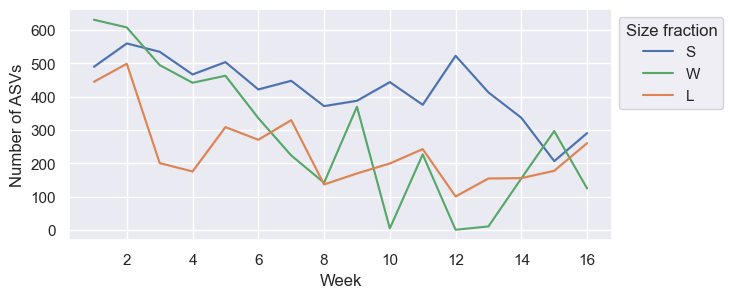

In [465]:
results = boxplot_depth(separated, comm, 10, 'nASVs', 'Number of ASVs')

In [466]:
results

S         W         L
S  1.000000  0.038420  0.000058
W  0.038420  1.000000  0.460574
L  0.000058  0.460574  1.000000

In [22]:
taxbarplot(separated, 'Phylum', 60, 10)

/var/folders/kv/yq6jygk116l27q2bwnk25k0w0000gn/T/ipykernel_64907/3398006415.py:19: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



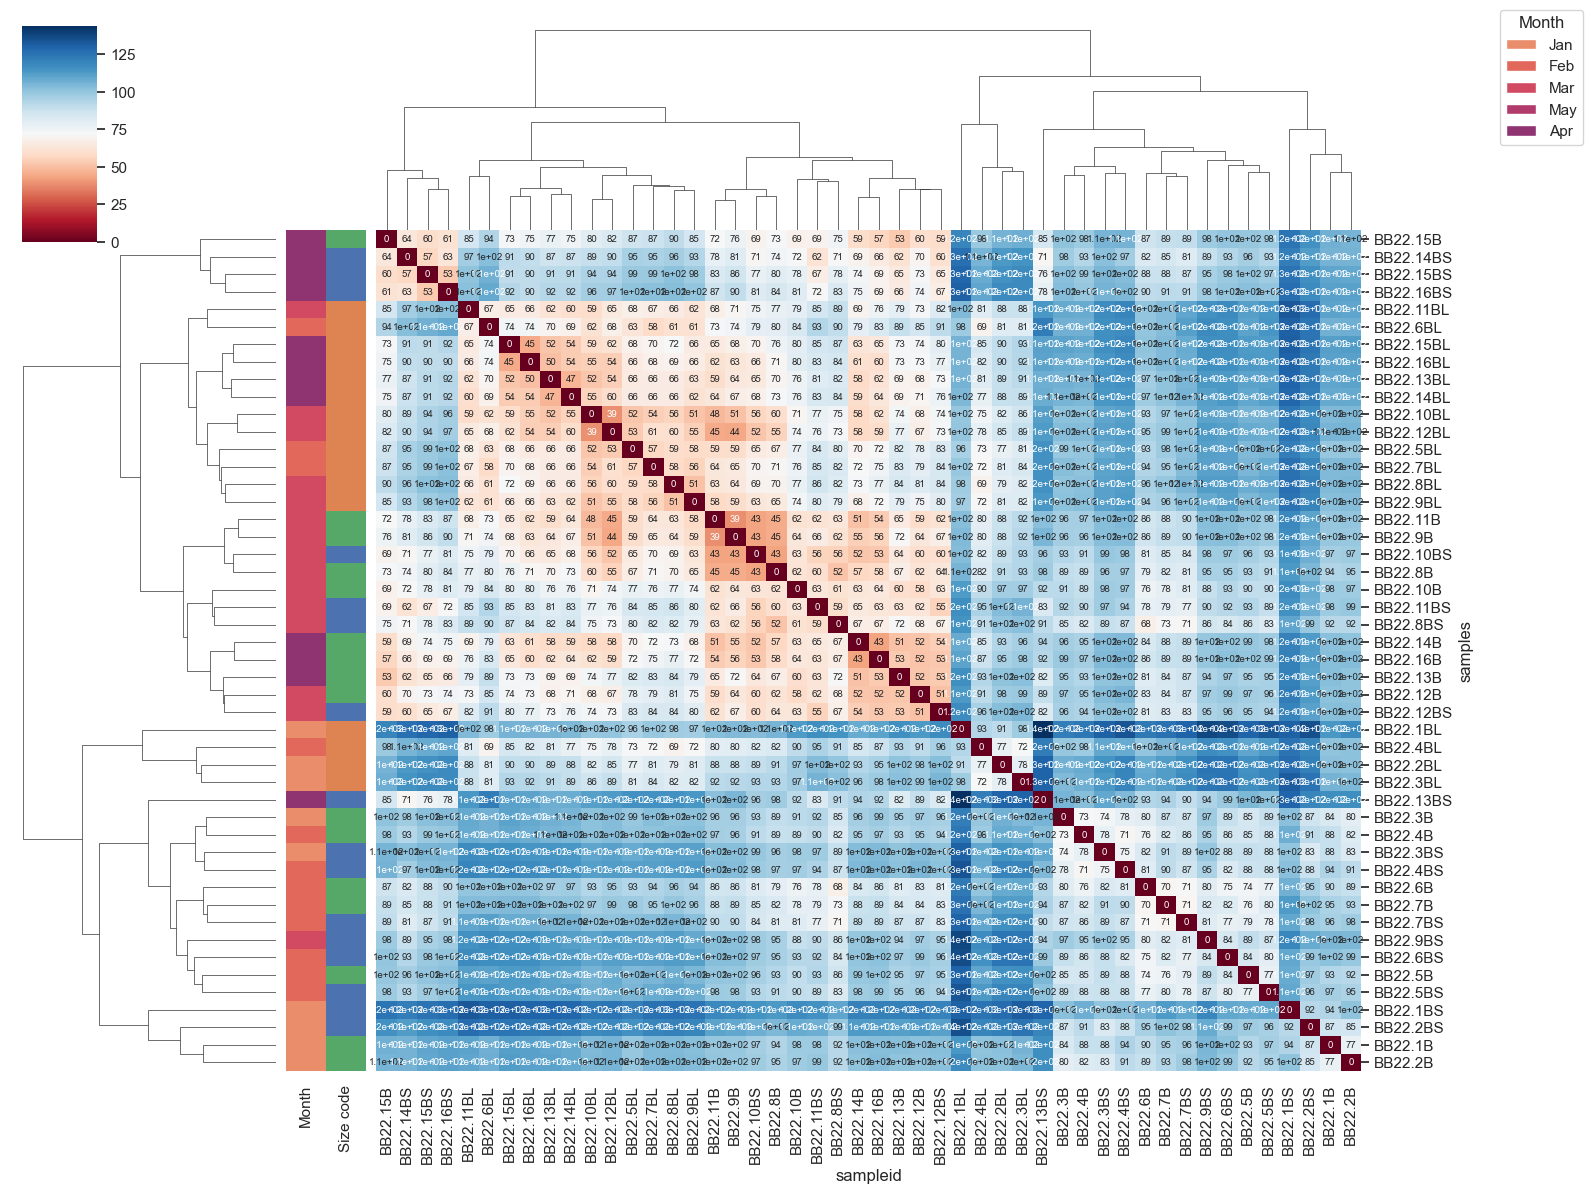

In [563]:
pca, pca_features, sfdclr = pcaplot(separated, 5, '16S')

** another idea is to run ancom of sizefraction specific and compare after the categories (run ancom on ?time or month.. or some other column) and compare the number/taxonomy of differentially abundant taxa recovered;
are we recovering the same diff ab taxa between the (1.SF samples, 2. NSF samples)

In [556]:
DARejected_SC_taxonomy_18_60

feature_id    W  Reject null hypothesis  Confidence                                              Taxon               Phylum                Class               Family            Genus                  Species
0  3ebfc5b9b1f20163a30c88a9d02b6952  125                    True    0.963728  d__Eukaryota; p__Kathablepharidae; c__Kathable...  p__Kathablepharidae  c__Kathablepharidae  f__Kathablepharidae  g__Leucocryptos  s__uncultured_eukaryote

In [535]:
DARejected_SC_taxonomy_18_1, prcentile = run_ancom(sfdclr, 1)

/Users/Diana/mambaforge/envs/qiime2-2023.5/lib/python3.8/site-packages/scipy/stats/_stats_py.py:3659: F_onewayConstantInputWarning:

Each of the input arrays is constant;the F statistic is not defined or infinite



/var/folders/kv/yq6jygk116l27q2bwnk25k0w0000gn/T/ipykernel_64907/3398006415.py:19: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/Users/Diana/mambaforge/envs/qiime2-2023.5/lib/python3.8/site-packages/scipy/stats/_stats_py.py:3659: F_onewayConstantInputWarning:

Each of the input arrays is constant;the F statistic is not defined or infinite



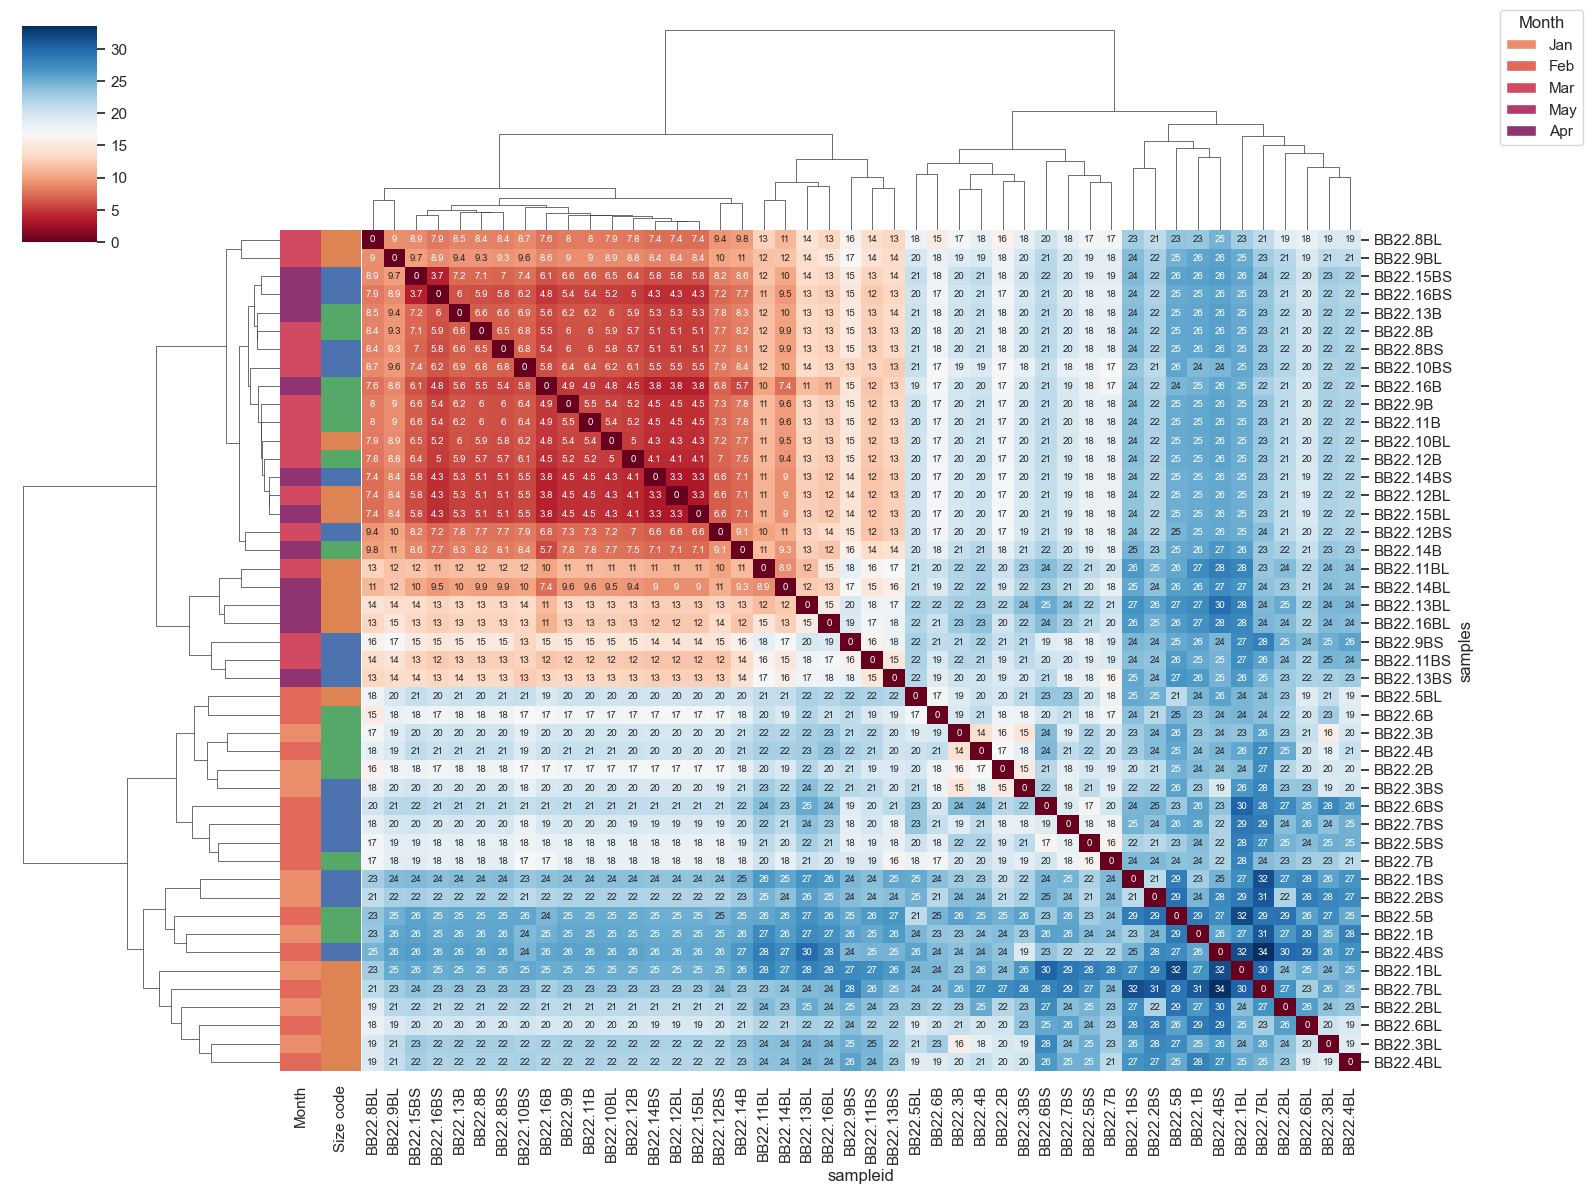

In [536]:
pca, pca_features, sfdclr = pcaplot(separated, 5, '18S')
DARejected_SC_taxonomy_18_5, prcentile = run_ancom(sfdclr, 5)

/var/folders/kv/yq6jygk116l27q2bwnk25k0w0000gn/T/ipykernel_64907/3398006415.py:19: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/Users/Diana/mambaforge/envs/qiime2-2023.5/lib/python3.8/site-packages/scipy/stats/_stats_py.py:3659: F_onewayConstantInputWarning:

Each of the input arrays is constant;the F statistic is not defined or infinite



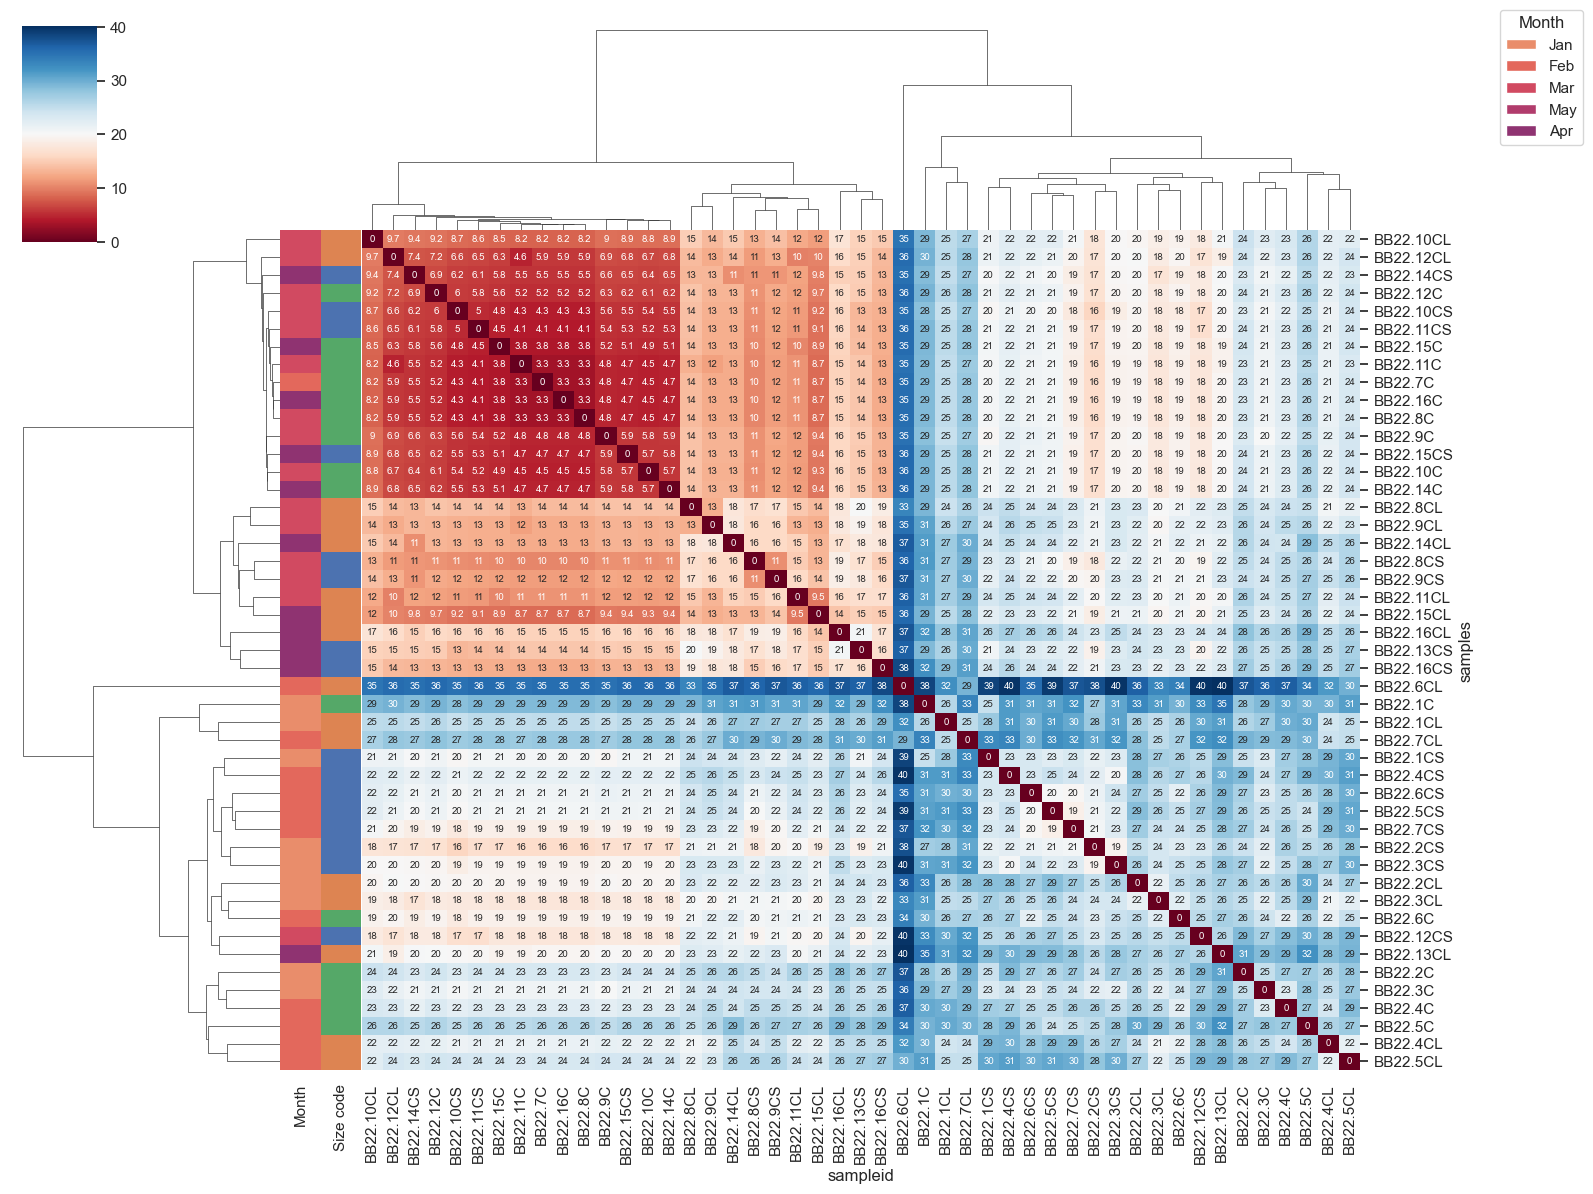

In [537]:
pca, pca_features, sfdclr = pcaplot(separated, 10, '18S')
DARejected_SC_taxonomy_18_10, prcentile = run_ancom(sfdclr, 10)

/var/folders/kv/yq6jygk116l27q2bwnk25k0w0000gn/T/ipykernel_64907/3398006415.py:19: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/Users/Diana/mambaforge/envs/qiime2-2023.5/lib/python3.8/site-packages/scipy/stats/_stats_py.py:3659: F_onewayConstantInputWarning:

Each of the input arrays is constant;the F statistic is not defined or infinite



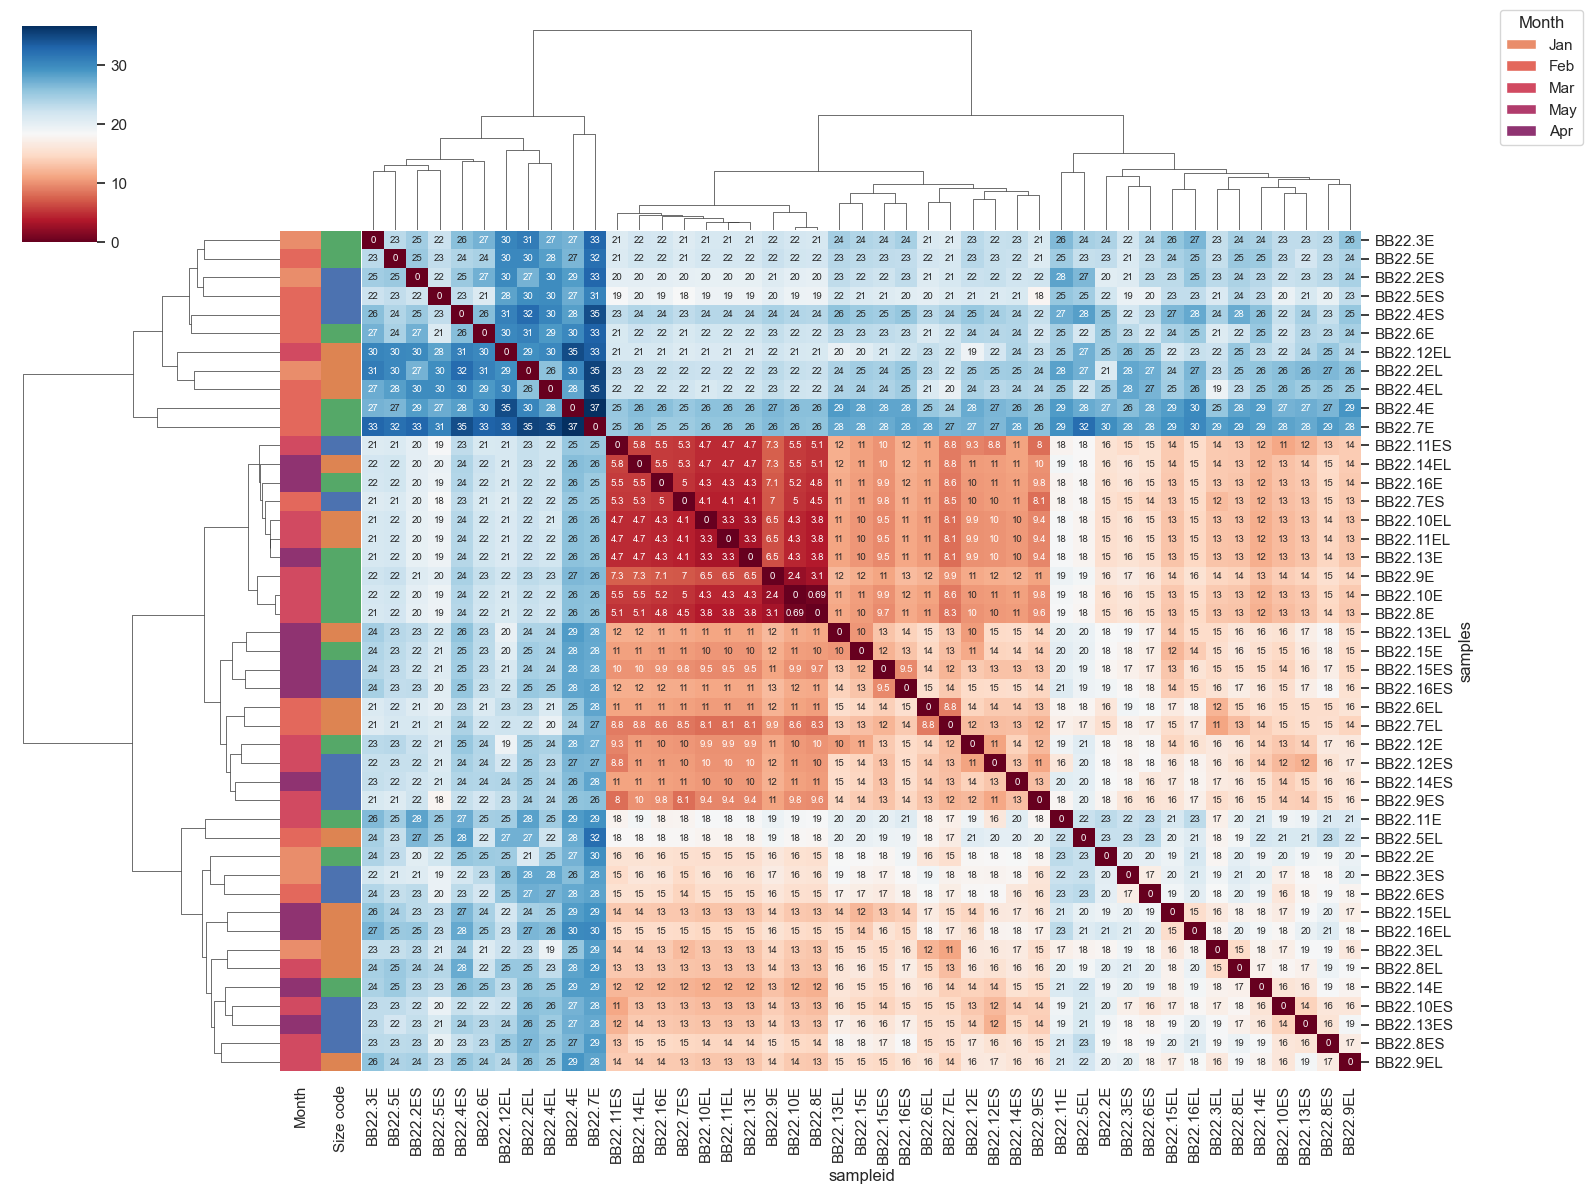

In [538]:
pca, pca_features, sfdclr = pcaplot(separated, 30, '18S')
DARejected_SC_taxonomy_18_30, prcentile = run_ancom(sfdclr, 30)

/var/folders/kv/yq6jygk116l27q2bwnk25k0w0000gn/T/ipykernel_64907/3398006415.py:19: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/Users/Diana/mambaforge/envs/qiime2-2023.5/lib/python3.8/site-packages/scipy/stats/_stats_py.py:3659: F_onewayConstantInputWarning:

Each of the input arrays is constant;the F statistic is not defined or infinite



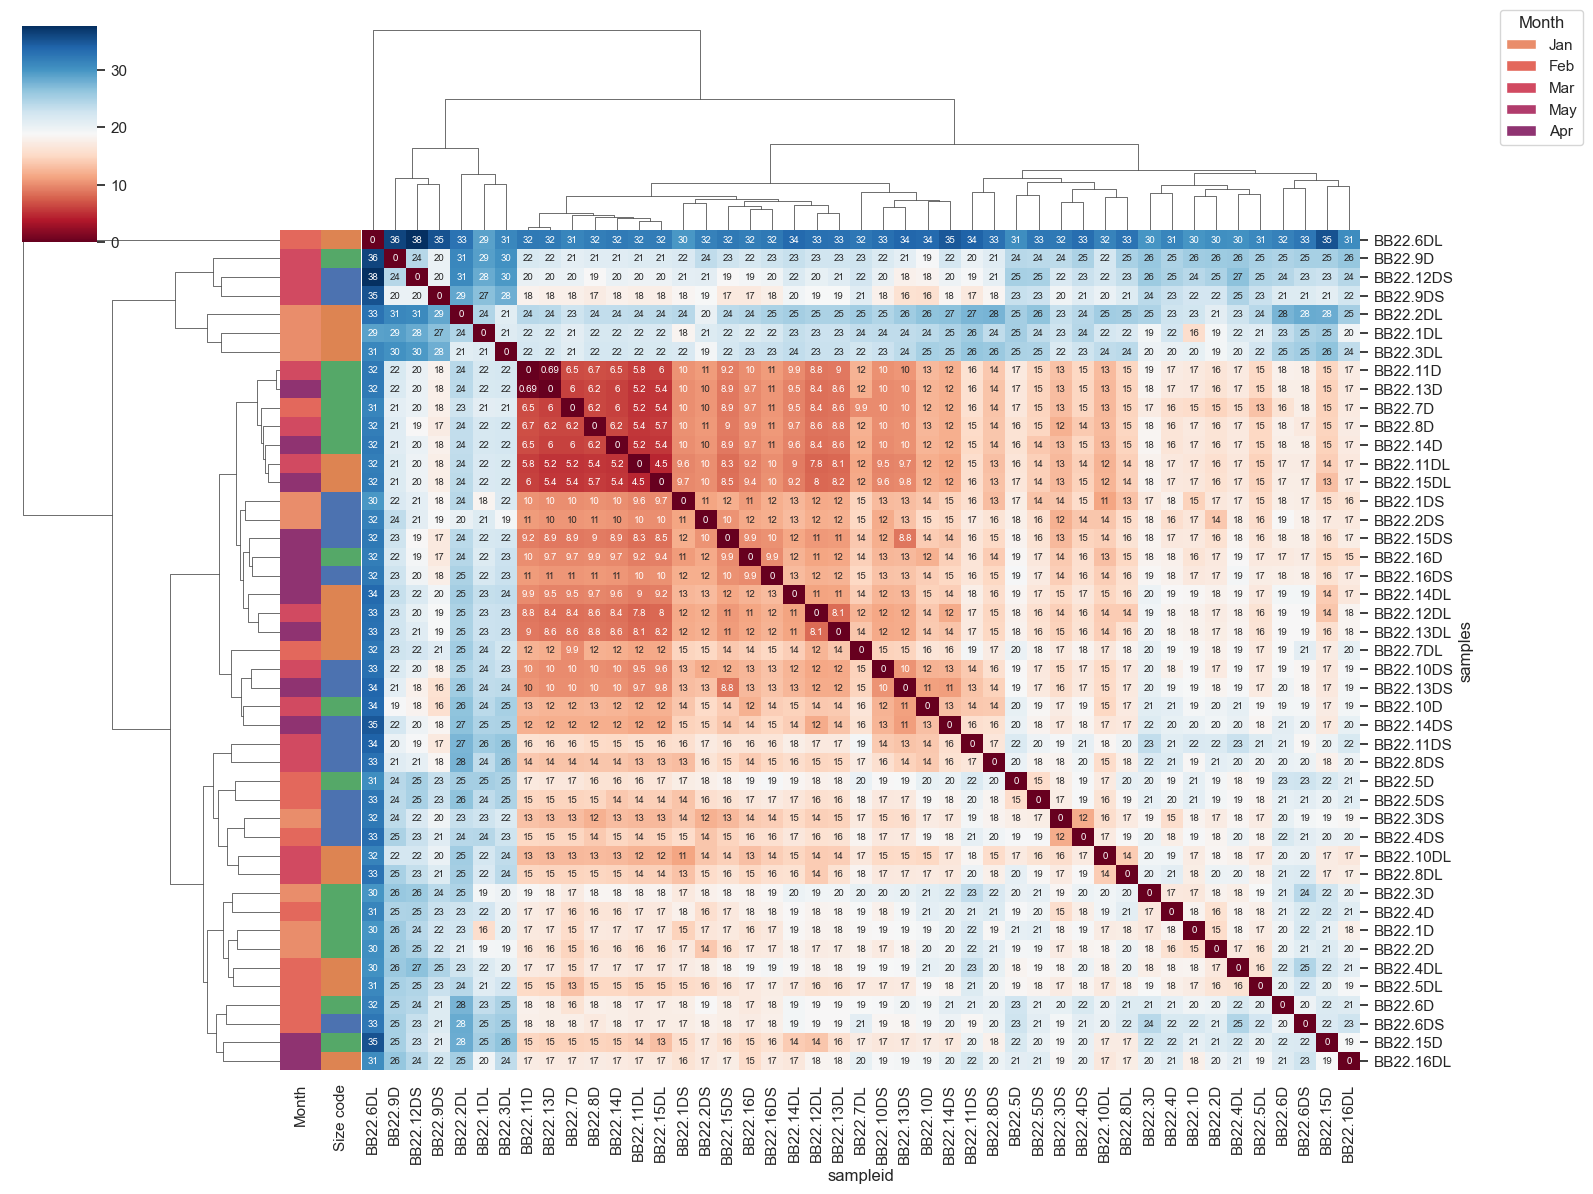

In [539]:
pca, pca_features, sfdclr = pcaplot(separated, 60, '18S')
DARejected_SC_taxonomy_18_60, prcentile = run_ancom(sfdclr, 60)

In [559]:
DARejected_SC_taxonomy.sort_values(by='W')

W  Reject null hypothesis
feature_id                                                    
fd5eeee9dda082827512f461eae9139e  2176                    True
b5c91d2ed1db7f5ec72fd7efc16512df  2178                    True
d5c7ef3f21279707b9836dfe508d0c50  2185                    True
0b32c57485134932672e134f70e73146  2188                    True
71fff8efc65855fe0cc9d28d00c5f7aa  2189                    True
...                                ...                     ...
c497da3b39f30aceede6bec3b03cd100  2380                    True
4d8e2372804de2264b3be37e87bb00a7  2386                    True
232219084f234c1b31d90324e6d1832f  2389                    True
54988ecf10dd5d89674a5517667bee14  2391                    True
ac9f56eb5dbfc3dc6b168fc73fc6c34c  2420                    True

[56 rows x 2 columns]

/var/folders/kv/yq6jygk116l27q2bwnk25k0w0000gn/T/ipykernel_64907/3398006415.py:19: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/Users/Diana/mambaforge/envs/qiime2-2023.5/lib/python3.8/site-packages/scipy/stats/_stats_py.py:3659: F_onewayConstantInputWarning:

Each of the input arrays is constant;the F statistic is not defined or infinite



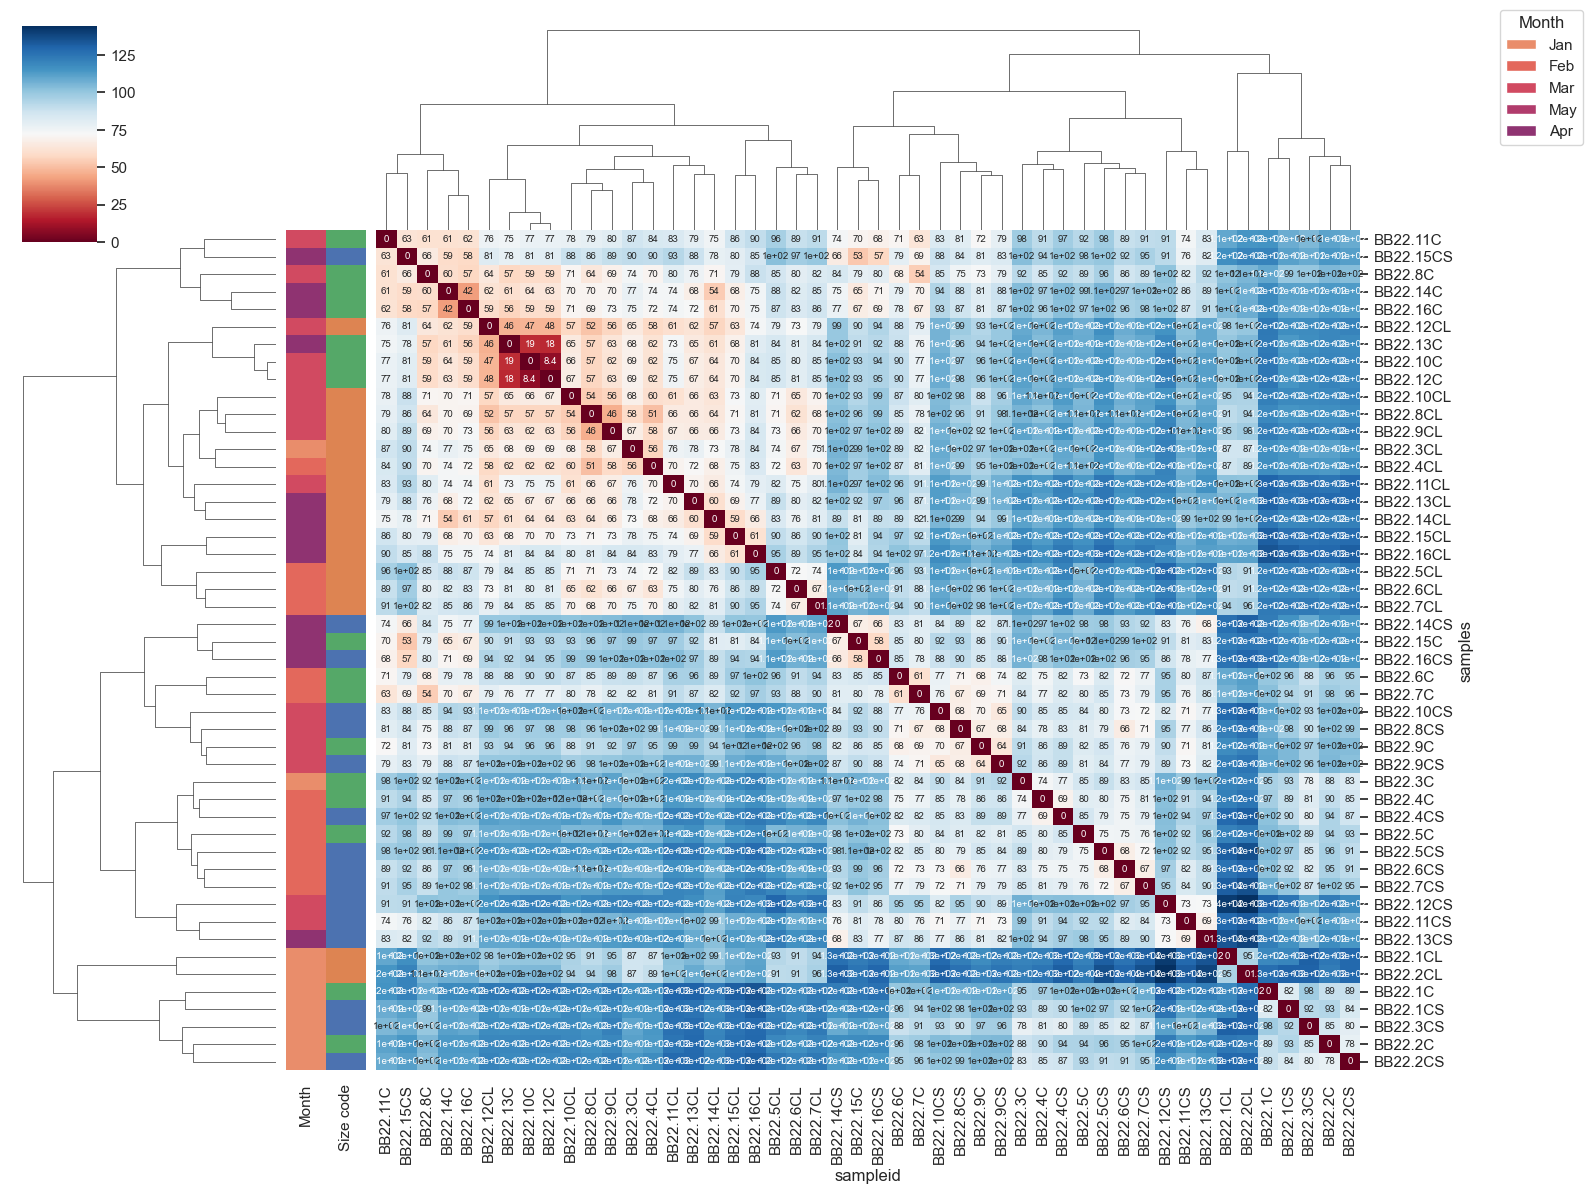

In [525]:
pca, pca_features, sfdclr10 = pcaplot(separated, 10, '16S')
DARejected_SC_taxonomy10, prcentile = run_ancom(sfdclr10, 10)

In [568]:
DARejected_SC_taxonomy10.sort_values(by='W')

W  Reject null hypothesis
feature_id                                                    
e7da1335cc9023e506df6af40d7ee069  1941                    True
2f72a212b9a2db1f2d4b1693515b67a1  1943                    True
898d6ab0223f9b1d3fe06d196883eeea  1949                    True
1816e09570f69294ef9acec1652a8455  1970                    True
77ea1e56373a9e7e3dfee2b70ff8e407  1972                    True
...                                ...                     ...
4d8e2372804de2264b3be37e87bb00a7  2381                    True
81e7d8f8843a16a20f0e7518365b2c12  2388                    True
401a67858704d406087efd35334e84e1  2398                    True
6a3f43ace0d5bb2a33b6f00cc49ba841  2403                    True
232219084f234c1b31d90324e6d1832f  2433                    True

[121 rows x 2 columns]

/var/folders/kv/yq6jygk116l27q2bwnk25k0w0000gn/T/ipykernel_64907/3398006415.py:19: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/Users/Diana/mambaforge/envs/qiime2-2023.5/lib/python3.8/site-packages/scipy/stats/_stats_py.py:3659: F_onewayConstantInputWarning:

Each of the input arrays is constant;the F statistic is not defined or infinite



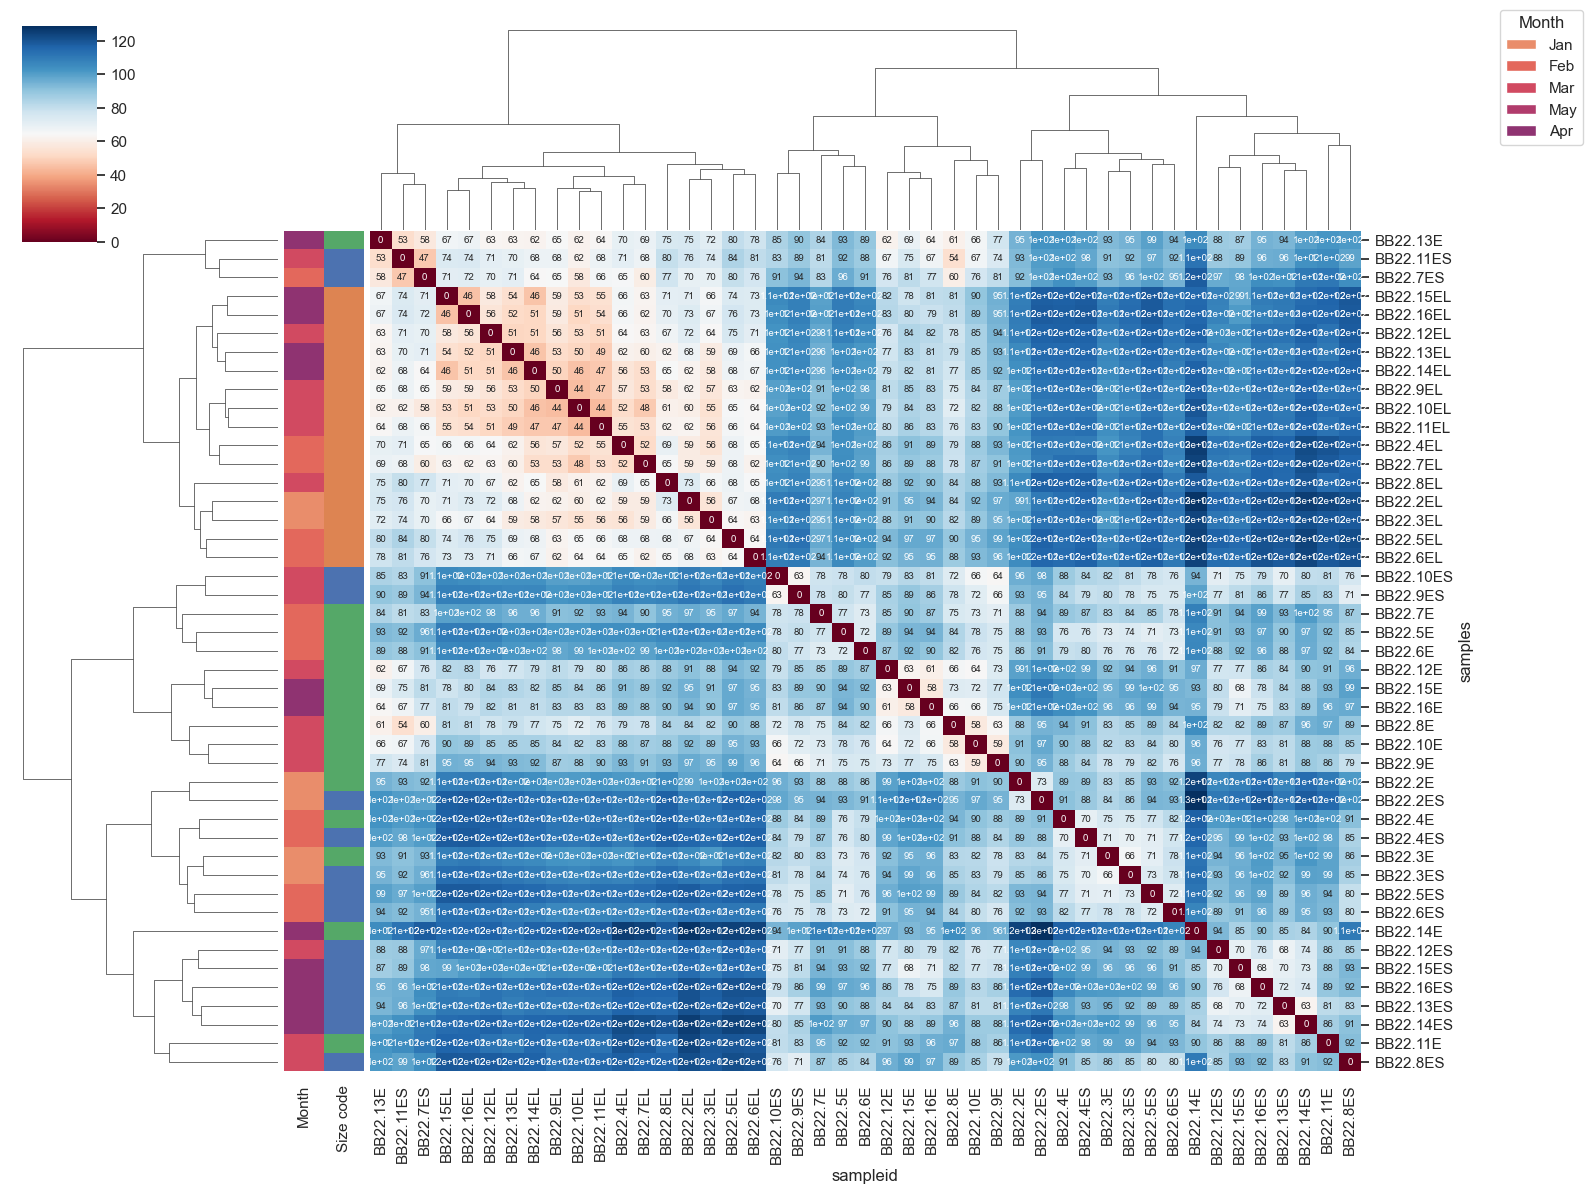

In [526]:
pca, pca_features, sfdclr30 = pcaplot(separated, 30, '16S')
DARejected_SC_taxonomy30, prcentile = run_ancom(sfdclr30, 30)

In [578]:
DARejected_SC_taxonomy30.sort_values(by='W')

W  Reject null hypothesis
feature_id                                                    
77ea1e56373a9e7e3dfee2b70ff8e407  1780                    True
e7da1335cc9023e506df6af40d7ee069  1783                    True
d0b5c17f487e0343cd177bd491e25c41  1783                    True
8de78294559168d41a2f0ec6196bff4f  1787                    True
1bca25e5db46692c21c5099605baa1ea  1790                    True
...                                ...                     ...
54988ecf10dd5d89674a5517667bee14  2177                    True
ac9f56eb5dbfc3dc6b168fc73fc6c34c  2190                    True
64b2411ef91c0e6c019f500c69cbbe03  2227                    True
d3f904c89fe4ebb73b13e028a5574924  2228                    True
588253f8c914de60cbb9577946854a39  2231                    True

[140 rows x 2 columns]

/var/folders/kv/yq6jygk116l27q2bwnk25k0w0000gn/T/ipykernel_64907/3398006415.py:19: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/Users/Diana/mambaforge/envs/qiime2-2023.5/lib/python3.8/site-packages/scipy/stats/_stats_py.py:3659: F_onewayConstantInputWarning:

Each of the input arrays is constant;the F statistic is not defined or infinite



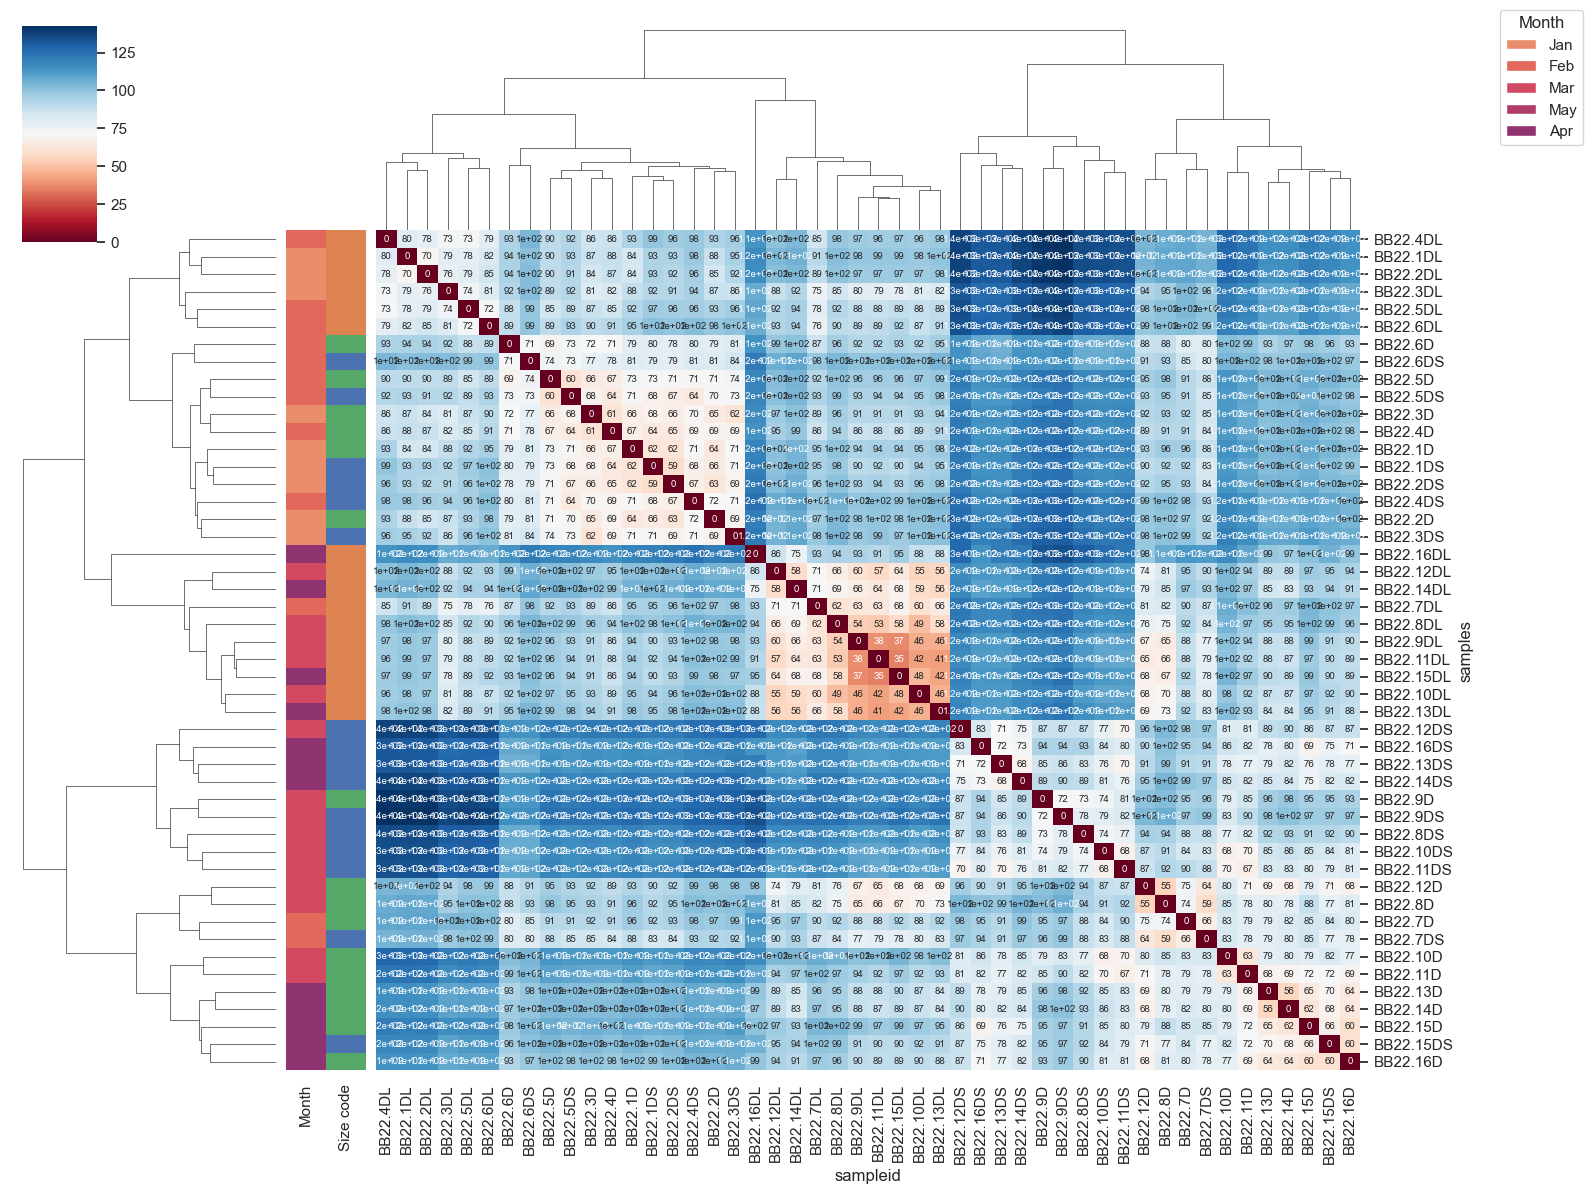

In [527]:
pca, pca_features, sfdclr60 = pcaplot(separated, 60, '16S')
DARejected_SC_taxonomy60, prcentile = run_ancom(sfdclr60, 60)

In [590]:
DARejected_SC_taxonomy60.sort_values(by='W')

W  Reject null hypothesis
feature_id                                                    
7898ba618b82b7794566199b204eca07  2226                    True
0bd2e49490c2c51a5094fef0a3ac86e7  2226                    True
bcdb61c897d859cb4a79a74f2bb09683  2229                    True
fa5605ff57383d139ad54b457bece20d  2237                    True
b26e9719b37840216a3b93669d4a6490  2238                    True
...                                ...                     ...
401a67858704d406087efd35334e84e1  2435                    True
2997f1920aefbb91632b549f2538b73b  2451                    True
1914aa84fc7f965e509b4302ae002c3e  2461                    True
54988ecf10dd5d89674a5517667bee14  2481                    True
1ce3b5c6d85ce967f8677e23e3e9b0be  2482                    True

[36 rows x 2 columns]

? run a clustermap of top10 taxa of each deapth and color rows by depth, month, size code

In [506]:
prcentile.loc[prcentile.index == '1bca25e5db46692c21c5099605baa1ea']

Percentile                       0.0   25.0  50.0  75.0  100.0 0.0     25.0   50.0    75.0   100.0 0.0   25.0  50.0    75.0   100.0
Group                                L     L     L     L     L     S       S      S       S      S     W     W     W       W      W
feature_id                                                                                                                         
401a67858704d406087efd35334e84e1   0.1   0.1   0.1   0.1   0.1  41.0  106.75  142.5  230.25  369.0   0.1  34.0  60.0  202.75  385.0

/var/folders/kv/yq6jygk116l27q2bwnk25k0w0000gn/T/ipykernel_64907/3398006415.py:19: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



KeyError: "['Month'] not in index"

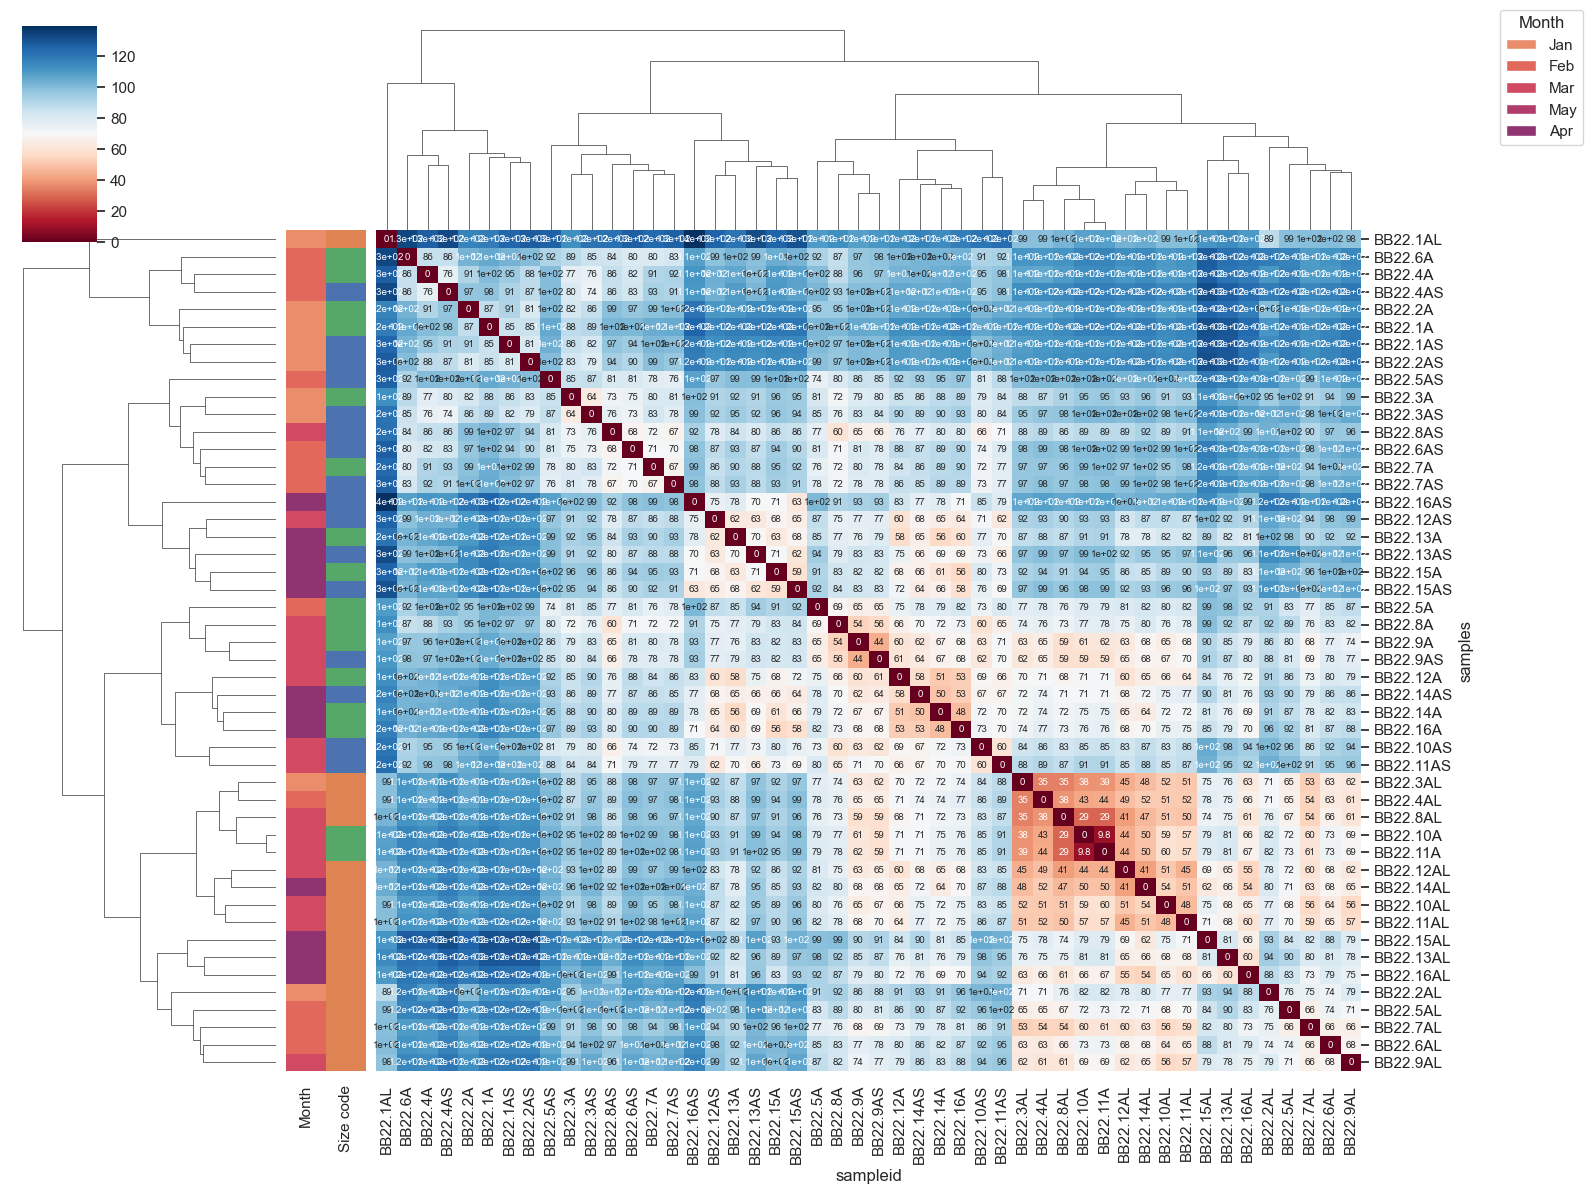

In [595]:
pca, pca_features, sfdclr = pcaplot(separated, 1, '16S')
DARejected_month_taxonomy_16_1, prcentile = run_ancom(sfdclr, 1, 'Month')

/var/folders/kv/yq6jygk116l27q2bwnk25k0w0000gn/T/ipykernel_64907/819531343.py:13: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/kv/yq6jygk116l27q2bwnk25k0w0000gn/T/ipykernel_64907/819531343.py:14: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/kv/yq6jygk116l27q2bwnk25k0w0000gn/T/ipykernel_64907/819531343.py:15: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the d

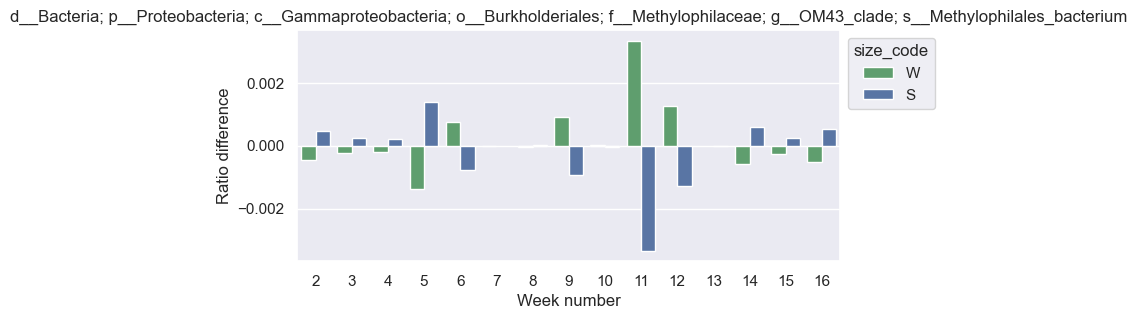

In [592]:
plot_per_fid('16S', separated, 30, '54988ecf10dd5d89674a5517667bee14')

In [270]:
plot_df2.sort_values('dim1')

sampleid      dim1      dim2 size_code  weekn
12584  BB22.8AL -0.142871  0.029140         L      8
12591  BB22.8AL -0.142871  0.029140         L      8
12590  BB22.8AL -0.142871  0.029140         L      8
12589  BB22.8AL -0.142871  0.029140         L      8
12588  BB22.8AL -0.142871  0.029140         L      8
...         ...       ...       ...       ...    ...
9099   BB22.4AS  0.180481  0.026792         S      4
9100   BB22.4AS  0.180481  0.026792         S      4
9101   BB22.4AS  0.180481  0.026792         S      4
9121   BB22.4AS  0.180481  0.026792         S      4
9039   BB22.4AS  0.180481  0.026792         S      4

[13449 rows x 5 columns]

### Upset plot data prep

In [600]:
upsetprep('16S', 'Genus')

In [ ]:
#if we want to make an upset plot of all depths?

frames = sfd1, sfd5, sfd10, sfd30, sfd60
result = pd.concat(frames)
resultpivot = result.pivot_table(index='Genus', columns='set_name', values='feature_frequency')
resultpivot = resultpivot.fillna(0)
resultpivot[resultpivot != 0] = 1
tosave = pd.merge(resultpivot, cumulab1, left_index=True, right_index=True)
tosave.to_csv('genus_all16S_relab.csv')

### Venn diagrams

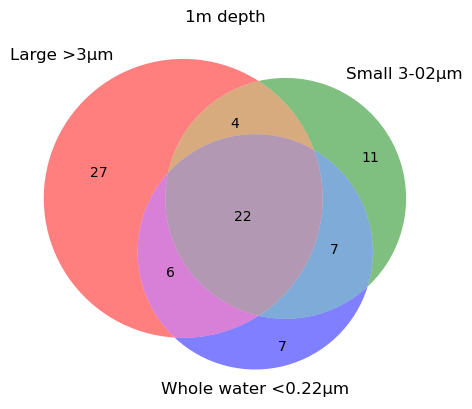

In [37]:
#Depth 1 all 16S at genus level
#N=84
venn3(subsets = (27, 11, 4, 7, 6, 7, 22), set_labels = ('Large >3μm', 'Small 3-02μm', 'Whole water <0.22μm'), alpha = 0.5);

plt.title("1m depth") 
plt.savefig("outputs/02-EUKs/D1_genus_venn.png")
plt.show()

In [433]:
lm = sfa.ols('nASVs ~ C(size_code)', data=sfd_LM).fit()
anova = sa.stats.anova_lm(lm)
sp.posthoc_ttest(sfd_LM, val_col='nASVs', group_col='size_code', p_adjust='holm')

df         sum_sq        mean_sq         F    PR(>F)
C(size_code)   2.0  209405.672748  104702.836374  4.935318  0.011761
Residual      43.0  912245.544643   21215.012666       NaN       NaN

In [416]:
sfd_S = sfd[['size_code', 'nASVs', 'weekn']].copy()
sfd_S = sfd_S.drop_duplicates()
sdfpv = sfd_S.pivot(index='weekn', columns='size_code', values='nASVs')
fvalue, pvalue = stats.f_oneway(sdfpv['L'], sdfpv['S'], sdfpv['W'])

In [427]:
sfd_LM = sfd[['size_code', 'nASVs']].copy()
sfd_LM = sfd_LM.drop_duplicates()
lm = sfa.ols('nASVs ~ C(size_code)', data=sfd_LM).fit()
anova = sa.stats.anova_lm(lm)
sp.posthoc_ttest(sfd_LM, val_col='nASVs', group_col='size_code', p_adjust='holm')

size_code  nASVs
0             S    287
9             S    303
20            W    182
21            S    289
31            W    296
...         ...    ...
420           W      5
474           L    101
539           L     68
1836          L     46
55883         W      3

[46 rows x 2 columns]

In [435]:
dffff = sp.posthoc_ttest(sfd_LM, val_col='nASVs', group_col='size_code', p_adjust='holm')
dffff

S         W         L
S  1.000000  0.344481  0.002840
W  0.344481  1.000000  0.118963
L  0.002840  0.118963  1.000000

In [420]:
sfd_S = sfd_S.drop_duplicates()

In [411]:
sfd_S = sfd_S.set_index('weekn')

In [412]:
sfd_sdf = sfd_S.stack().to_frame().reset_index()

In [421]:
sdfpv = sfd_S.pivot(index='weekn', columns='size_code', values='nASVs')

In [422]:
sdfpv

size_code    L    S    W
weekn                   
1          546  539  600
2          288  522  539
3           65  364  332
4           68  512  516
5          259  427  268
...        ...  ...  ...
12          83  289  182
13         222  319  296
14         101  175  194
15         262  303  311
16         157  364  202

[16 rows x 3 columns]

In [425]:
fvalue, pvalue = stats.f_oneway(sdfpv['L'], sdfpv['S'], sdfpv['W'])

In [426]:
pvalue

0.008723050173397731

In [378]:
#Euks
SLSL = [50, 41.56, 39.36, 31.51, 47.76]
WO = [8.33,7.79, 8.51, 19.18, 8.96]
LSLSWSW = [41.67, 50.65, 52.13, 49.32, 43.28]
depth = [1, 5, 10, 30, 60]

dfprofile = pd.DataFrame({'SF_years': SLSL,'NSF_years':WO, 'Always':LSLSWSW, 'Depth':depth})

In [389]:
#Proks
SLSL = [33.03, 40.64, 37.92, 24.72, 35.24]
WO = [11.77, 7.52, 6.57, 14.76, 6.26]
LSLSWSW = [55.20, 51.84, 55.51, 60.52, 58.50]
depth = [1, 5, 10, 30, 60]

dfprofile = pd.DataFrame({'SF_years': SLSL,'NSF_years':WO, 'Always':LSLSWSW, 'Depth':depth})

In [388]:
dfprofile = dfprofile.set_index('Depth')

In [318]:
dfprofileseries = dfprofile.stack()

In [319]:
dfprofile = dfprofileseries.to_frame().reset_index()

In [320]:
dfprofile = dfprofile.set_index('Depth')

In [321]:
dfprofile = dfprofile.rename(columns= {'level_1': 'Set', 0: 'Percentage'})

In [391]:
df_grouped = dfprofile.copy()

In [392]:
df_grouped

SF_years  NSF_years  Always  Depth
0     33.03      11.77   55.20      1
1     40.64       7.52   51.84      5
2     37.92       6.57   55.51     10
3     24.72      14.76   60.52     30
4     35.24       6.26   58.50     60

In [393]:
df_grouped['Depth'] = df_grouped['Depth'].astype(str)

In [394]:
df_grouped = df_grouped.set_index('Depth')

In [395]:
df_grouped

SF_years  NSF_years  Always
Depth                             
1         33.03      11.77   55.20
5         40.64       7.52   51.84
10        37.92       6.57   55.51
30        24.72      14.76   60.52
60        35.24       6.26   58.50

In [779]:
# variables
labels = ['SF samples', 'NSF samples','Both']
colors = ['#1D2F6F', '#8390FA', '#6EAF46']
title = 'Weighted roportion of shared genus between size fractionated and non size fractionated samples'
#subtitle = 'From Jan7 2022 to Apr27 2022'
def plot_stackedbar_p(df, labels, colors, title, subtitle):
    fields = df.columns.tolist()
    
    # figure and axis
    fig, ax = plt.subplots(1, figsize=(8, 5))
# plot bars
    left = len(df) * [0]
    for idx, name in enumerate(fields):
        plt.barh(df.index, df[name], left = left, color=colors[idx])
        left = left + df[name]
# title and subtitle
    plt.title(title, loc='left')
    #plt.text(0, ax.get_yticks()[-1] + 0.75, subtitle)
# legend
    plt.legend(labels, bbox_to_anchor=([1, 1, 0, 0]), ncol=1, frameon=False)
# remove spines
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
# format x ticks
    xticks = np.arange(0,110,10)
    xlabels = ['{}%'.format(i) for i in np.arange(0,101,10)]
    plt.xticks(xticks, xlabels)
# adjust limits and draw grid lines
    plt.ylim(-0.5, ax.get_yticks()[-1] + 0.5)
    ax.xaxis.grid(color='gray', linestyle='dashed')
    plt.gca().invert_yaxis()
    plt.ylabel("Depth (m)")
    plt.show()
    plt.savefig('outputs/02-PROKs/alldepths_stacked_perc_weighted.png', dpi=200, bbox_inches="tight")

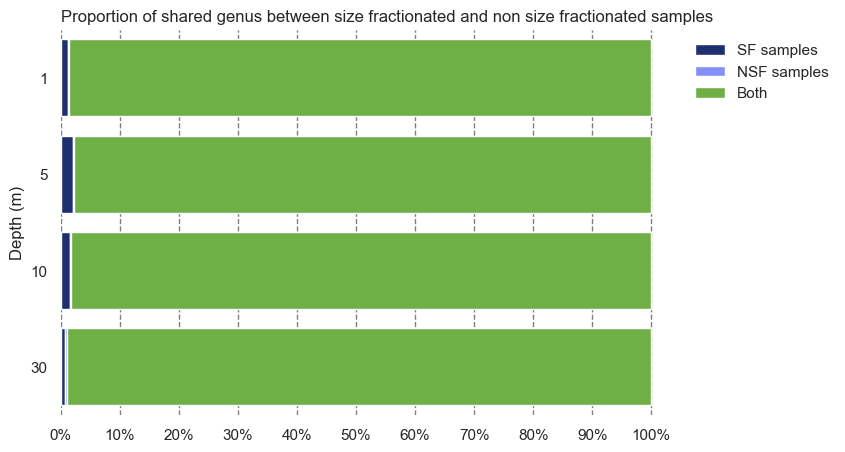

<Figure size 400x300 with 0 Axes>

In [778]:
plot_stackedbar_p(dfplot, labels, colors, title, subtitle)

In [ ]:
plt.savefig('outputs/'+comm_id+'/D'+str(depth)+'_adlineplot.png', dpi=200, bbox_inches="tight")

In [396]:
df_grouped.describe()

SF_years  NSF_years     Always
count   5.000000    5.00000   5.000000
mean   34.310000    9.37600  56.314000
std     6.073969    3.73318   3.330658
min    24.720000    6.26000  51.840000
25%    33.030000    6.57000  55.200000
50%    35.240000    7.52000  55.510000
75%    37.920000   11.77000  58.500000
max    40.640000   14.76000  60.520000

In [776]:
def calcperc(comm, separated):
    
    if comm == '16S':
        comm_id = '02-PROKs'
    else:
        comm_id = '02-EUKs'
        
    depths = [1, 5, 10, 30, 60]
    
    dfplot = pd.DataFrame(columns=['Depth', 'SF', 'NSF', 'Both'])
    
    for d in range(len(depths)-1):
        sfd=separated[separated.depth==depths[d]]
        toptaxa = sfd[['feature_id', 'feature_frequency', 'Taxon', 'size_code', 'weekn']].copy()
    
        toptaxa = toptaxa.drop_duplicates()
        df_agg = toptaxa.groupby(['size_code','feature_id']).agg({'feature_frequency':sum})
    
        df_agg = df_agg.reset_index()
        resultpivot = df_agg.pivot_table(index='feature_id', columns='size_code', values='feature_frequency')
        resultpivot = resultpivot.fillna(0)
    
        df = resultpivot.copy()
    
        Sonly = df[(df['L'] == 0) & (df['W'] == 0)]
        Wonly = df[(df['L'] == 0) & (df['S'] == 0)]
        Lonly = df[(df['S'] == 0) & (df['W'] == 0)]
        LW = df[(df['S'] == 0) & (df['W'] != 0) & (df['L'] != 0)]
        LS = df[(df['W'] == 0) & (df['S'] != 0) & (df['L'] != 0)]
        SW = df[(df['W'] != 0) & (df['S'] != 0) & (df['L'] == 0)]
        LSW = df[~(df == 0).any(axis=1)]
    
        total = df.to_numpy().sum()
    
        SFdf = Lonly, LS, Sonly
        SF = pd.concat(SFdf)
        SF_value = SF.to_numpy().sum()/total *100
    
        Bothdf = LW, LSW, SW
        Both = pd.concat(Bothdf)
        Both_value = Both.to_numpy().sum()/total *100
    
        Wonly_value = Wonly.to_numpy().sum()/total *100
        
        dfplot.loc[d,'Depth'] = depths[d]
        dfplot.loc[d,'SF'] = SF_value
        dfplot.loc[d,'NSF'] = Wonly_value
        dfplot.loc[d,'Both'] = Both_value
    
    dfplot['Depth'] = dfplot['Depth'].astype(str)
    dfplot = dfplot.set_index('Depth')
        
    return dfplot

In [777]:
dfplot = calcperc('16S', separated)

In [772]:
dfplot

SF       NSF       Both
Depth                               
1       1.22623  0.241694  98.532076
5      2.059965  0.178634  97.761401
10     1.551926  0.153331  98.294743
30     0.697965  0.286048  99.015987

In [749]:
df = pd.DataFrame(columns=['Depth', 'SF', 'NSF', 'Both'])

In [750]:
d=1

In [753]:
depths = [1, 5, 10, 30, 60]

In [756]:
range(len(depths)-1)

range(0, 4)

In [757]:
depths[0]

1

In [751]:
df.loc[d,'Depth'] = depths[d]
df.loc[d,'SF'] = SF_value
df.loc[d,'NSF'] = Wonly_value
df.loc[d,'Both'] = Both_value

In [752]:
df

Depth   SF  NSF Both
0     1  NaN  NaN  NaN

In [744]:
total = df.to_numpy().sum()

In [747]:
SF_value = SF.to_numpy().sum()/total *100

In [748]:
SF_value

1.2262304941958153

In [ ]:
# variables
labels = ['SF samples', 'NSF samples','Both']
colors = ['#1D2F6F', '#8390FA', '#6EAF46']
title = 'Proportion of shared genus between size fractionated and non size fractionated samples'
#subtitle = 'From Jan7 2022 to Apr27 2022'
def plot_stackedbar_p(df, labels, colors, title, subtitle):
    fields = df.columns.tolist()
    
    # figure and axis
    fig, ax = plt.subplots(1, figsize=(8, 5))
# plot bars
    left = len(df) * [0]
    for idx, name in enumerate(fields):
        plt.barh(df.index, df[name], left = left, color=colors[idx])
        left = left + df[name]
# title and subtitle
    plt.title(title, loc='left')
    #plt.text(0, ax.get_yticks()[-1] + 0.75, subtitle)
# legend
    plt.legend(labels, bbox_to_anchor=([1, 1, 0, 0]), ncol=1, frameon=False)
# remove spines
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
# format x ticks
    xticks = np.arange(0,110,10)
    xlabels = ['{}%'.format(i) for i in np.arange(0,101,10)]
    plt.xticks(xticks, xlabels)
# adjust limits and draw grid lines
    plt.ylim(-0.5, ax.get_yticks()[-1] + 0.5)
    ax.xaxis.grid(color='gray', linestyle='dashed')
    plt.gca().invert_yaxis()
    plt.ylabel("Depth (m)")
plt.show()

plot_stackedbar_p(df_grouped, labels, colors, title, subtitle)
plt.savefig('outputs/02-EUKs/alldepths_stacked_perc.png', dpi=200, bbox_inches="tight")